In [36]:
import arviz as az
import numpy as np
import pymc as pm
import pytensor.tensor as pt
from matplotlib import pyplot
import scipy.stats as st
import scipy.signal
import scipy.integrate
import pandas
import openpyxl
import time
import json
import math

In [33]:
# Amino acid Payzia 35 min, Part 2
# name of the measurement batch
batch = "2023_01_19_Testdatensatz"
# name of the acquisitions
acquisitions = [
    'A1_t1_1_Part2',
    'A2_t2_1_Part2',
    'A3_t3_1_Part2',
    'A4_t4_1_Part2',
    'A5_t5_1_Part2',
    'A6_t6_1_Part2',
    'A7_t7_1_Part2',
    'A8_t8_1_Part2',
    'B1_t1_2_Part2',
    'B7_t7_2_Part2',
    'B8_t8_2_Part2',
    'C1_t1_3_Part2',
    'C8_t8_3_Part2',
    'D5_t13_1_Part2',
    'E5_t13_2_Part2',
    'F5_t13_3_Part2'
]
# all information pertaining to XIC extraction, i.e. "time": [t_start, t_end, t_ret], "MS_info": [[precursor m/z, product m/z start, product m/z end, mass trace],...]
user_info = {
    # 'Val55':{
    #     "time": [8, 12, 9.9],
    #     "MS_info": [
    #         [118, 54.95, 55.15, 'M0_m0', True, "2nd"],
    #         [119, 54.95, 55.15, 'M1_m0', True, "2nd"],
    #         [119, 55.95, 56.15, 'M1_m1', True, "2nd"],
    #         [120, 55.95, 56.15, 'M2_m1', True, "2nd"],
    #         [120, 56.95, 57.15, 'M2_m2', True, "2nd"],
    #         [121, 56.95, 57.15, 'M3_m2', True, "2nd"],
    #         [121, 57.95, 58.15, 'M3_m3', True, "2nd"],
    #         [122, 57.95, 58.15, 'M4_m3', False, "2nd"],
    #         [122, 58.95, 59.15, 'M4_m4', False, "2nd"],
    #         [123, 58.95, 59.15, 'M5_m4', False, "2nd"]],
    #     "double_peak": False,
    #     "duplicate": True,
    # },
    # 'Val72':{
    #     "time": [8, 12, 9.9],
    #     "MS_info": [
    #         [118, 71.98, 72.18, 'M0_m0', True, "2nd"],
    #         [119, 71.98, 72.18, 'M1_m0', True, "2nd"],
    #         [119, 72.98, 73.18, 'M1_m1', True, "2nd"],
    #         [120, 72.98, 73.18, 'M2_m1', True, "2nd"],
    #         [120, 73.98, 74.18, 'M2_m2', True, "2nd"],
    #         [121, 73.98, 74.18, 'M3_m2', True, "2nd"],
    #         [121, 74.98, 75.18, 'M3_m3', True, "2nd"],
    #         [122, 74.98, 75.18, 'M4_m3', False, "2nd"],
    #         [122, 75.98, 76.18, 'M4_m4', False, "2nd"],
    #         [123, 75.98, 76.18, 'M5_m4', False, "2nd"]],
    #     "double_peak": False,
    #     "duplicate": True,
    # },
    # 'Orn70':{
    #     "time": [24, 27.5, 25.8],
    #     "MS_info": [
    #         [133, 69.96, 70.16, 'M0_m0'],
    #         [134, 69.96, 70.16, 'M1_m0'],
    #         [134, 70.96, 71.16, 'M1_m1'],
    #         [135, 70.96, 71.16, 'M2_m1'],
    #         [135, 71.96, 72.16, 'M2_m2'],
    #         [136, 71.96, 72.16, 'M3_m2'],
    #         [136, 72.96, 73.16, 'M3_m3'],
    #         [137, 72.96, 73.16, 'M4_m3'],
    #         [137, 73.96, 74.16, 'M4_m4'],
    #         [138, 73.96, 74.16, 'M5_m4']],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Pro70':{
    #     "time": [6, 9, 7.8],
    #     "MS_info": [
    #         [116, 69.96, 70.16, 'M0_m0', False, "1st"],
    #         [117, 69.96, 70.16, 'M1_m0', False, "1st"],
    #         [117, 70.96, 71.16, 'M1_m1', False, "1st"],
    #         [118, 70.96, 71.16, 'M2_m1', True, "1st"],
    #         [118, 71.96, 72.16, 'M2_m2', True, "1st"],
    #         [119, 71.96, 72.16, 'M3_m2', True, "1st"],
    #         [119, 72.96, 73.16, 'M3_m3', True, "1st"],
    #         [120, 72.96, 73.16, 'M4_m3', True, "1st"],
    #         [120, 73.96, 74.16, 'M4_m4', True, "1st"],
    #         [121, 73.96, 74.16, 'M5_m4', True, "1st"]],
    #     "double_peak": False,
    #     "duplicate": True,
    # },
    # 'Met104':{
    #     "time": [4, 7, 5.2],
    #     "MS_info": [
    #         [150, 103.95, 104.15, 'M0_m0', True, "1st"],
    #         [151, 103.95, 104.15, 'M1_m0', True, "1st"],
    #         [151, 104.95, 105.15, 'M1_m1', True, "1st"],
    #         [152, 104.95, 105.15, 'M2_m1', True, "1st"],
    #         [152, 105.95, 106.15, 'M2_m2', True, "1st"],
    #         [153, 105.95, 106.15, 'M3_m2', True, "1st"],
    #         [153, 106.95, 107.15, 'M3_m3', True, "1st"],
    #         [154, 106.95, 107.15, 'M4_m3', False, "1st"],
    #         [154, 107.95, 108.15, 'M4_m4', False, "1st"],
    #         [155, 107.95, 108.15, 'M5_m4', False, "1st"]],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Met133':{
    #     "time": [4, 7, 5.2],
    #     "MS_info": [
    #         [150, 132.93, 133.13, 'M0_m0', True, "1st"],
    #         [151, 133.93, 134.13, 'M1_m1', True, "1st"],
    #         [152, 134.93, 135.13, 'M2_m2', True, "1st"],
    #         [153, 135.93, 136.13, 'M3_m3', True, "1st"],
    #         [154, 136.93, 137.13, 'M4_m4', False, "1st"],
    #         [155, 137.93, 138.13, 'M5_m5', False, "1st"]],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    'His110':{
        "time": [24.5, 29, 26.2],
        "MS_info": [
            [156, 109.97, 110.17, 'M0_m0'],
            [157, 109.97, 110.17, 'M1_m0'],
            [157, 110.97, 111.17, 'M1_m1'],
            [158, 110.97, 111.17, 'M2_m1'],
            [158, 111.97, 112.17, 'M2_m2'],
            [159, 111.97, 112.17, 'M3_m2'],
            [159, 112.97, 113.17, 'M3_m3'],
            [160, 112.97, 113.17, 'M4_m3'],
            [160, 113.97, 114.17, 'M4_m4'],
            [161, 113.97, 114.17, 'M5_m4'],
            [161, 114.97, 115.17, 'M5_m5'],
            [162, 114.97, 115.17, 'M6_m5']],
        "double_peak": False,
        "duplicate": False,
    },
    # 'Lys84':{
    #     "time": [25.5, 28.5, 26.9],
    #     "MS_info": [
    #         [147, 84.0, 84.2, 'M0_m0', False, "1st"],
    #         [148, 84.0, 84.2, 'M1_m0', False, "1st"],
    #         [148, 85.0, 85.2, 'M1_m1', False, "1st"],
    #         [149, 85.0, 85.2, 'M2_m1', False, "1st"],
    #         [149, 86.0, 86.2, 'M2_m2', False, "1st"],
    #         [150, 86.0, 86.2, 'M3_m2', True, "2nd"],
    #         [150, 87.0, 87.2, 'M3_m3', True, "2nd"],
    #         [151, 87.0, 87.2, 'M4_m3', True, "2nd"],
    #         [151, 88.0, 88.2, 'M4_m4', True, "2nd"],
    #         [152, 88.0, 88.2, 'M5_m4', True, "2nd"],
    #         [152, 89.0, 89.2, 'M5_m5', True, "2nd"],
    #         [153, 89.0, 89.2, 'M6_m5', True, "2nd"]],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Lys130':{
    #     "time": [25.5, 28.5, 26.9],
    #     "MS_info": [
    #         [147, 130.0, 130.2, 'M0_m0', False, "1st"],
    #         [148, 131.0, 131.2, 'M1_m1', False, "1st"],
    #         [149, 132.0, 132.2, 'M2_m2', False, "1st"],
    #         [150, 133.0, 133.2, 'M3_m3', True, "2nd"],
    #         [151, 134.0, 134.2, 'M4_m4', True, "2nd"],
    #         [152, 135.0, 135.2, 'M5_m5', True, "2nd"],
    #         [153, 136.0, 136.2, 'M6_m6', True, "2nd"]],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Arg60':{
    #     "time": [28, 31.5, 29.9],
    #     "MS_info": [
    #         [175, 69.96, 70.16, 'M0_m0', False, "1st"],
    #         [176, 69.96, 70.16, 'M1_m0', True, "2nd"],
    #         [176, 70.96, 71.16, 'M1_m1', True, "2nd"],
    #         [177, 69.96, 70.16, 'M2_m0', True, "2nd"],
    #         [177, 70.96, 71.16, 'M2_m1', True, "2nd"],
    #         [178, 69.96, 70.16, 'M3_m0', True, "2nd"],
    #         [178, 70.96, 71.16, 'M3_m1', True, "2nd"],
    #         [179, 69.96, 70.16, 'M4_m0', True, "2nd"],
    #         [179, 70.96, 71.16, 'M4_m1', True, "2nd"],
    #         [180, 69.96, 70.16, 'M5_m0', True, "2nd"],
    #         [180, 70.96, 71.16, 'M5_m1', True, "2nd"],
    #         [181, 70.96, 71.16, 'M6_m1', True, "2nd"]],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Arg70':{
    #     "time": [28, 31.5, 29.9],
    #     "MS_info": [
    #         [175, 69.96, 70.16, 'M0_m0', False, "1st"],
    #         [176, 69.96, 70.16, 'M1_m0', True, "2nd"],
    #         [176, 70.96, 71.16, 'M1_m1', True, "2nd"],
    #         [177, 69.96, 70.16, 'M2_m0', True, "2nd"],
    #         [177, 70.96, 71.16, 'M2_m1', True, "2nd"],
    #         [177, 71.96, 72.16, 'M2_m2', True, "2nd"],
    #         [178, 70.96, 71.16, 'M3_m1', True, "2nd"],
    #         [178, 71.96, 72.16, 'M3_m2', True, "2nd"],
    #         [178, 72.96, 73.16, 'M3_m3', True, "2nd"],
    #         [179, 71.96, 72.16, 'M4_m2', True, "2nd"],
    #         [179, 72.96, 73.16, 'M4_m3', True, "2nd"],
    #         [179, 73.96, 74.16, 'M4_m4', True, "2nd"],
    #         [180, 72.96, 73.16, 'M5_m3', True, "2nd"],
    #         [180, 73.96, 74.16, 'M5_m4', True, "2nd"],
    #         [181, 73.96, 74.16, 'M6_m4', True, "2nd"]],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Cit70':{
    #     "time": [7, 10.5, 9.1],
    #     "MS_info": [
    #         [176, 69.96, 70.16, 'M0_m0', True, "1st"],
    #         [177, 69.96, 70.16, 'M1_m0', True, "1st"],
    #         [177, 70.96, 71.16, 'M1_m1', True, "1st"],
    #         [178, 69.96, 70.16, 'M2_m0', True, "1st"],
    #         [178, 70.96, 71.16, 'M2_m1', True, "1st"],
    #         [178, 71.96, 72.16, 'M2_m2', True, "1st"],
    #         [179, 70.96, 71.16, 'M3_m1', True, "1st"],
    #         [179, 71.96, 72.16, 'M3_m2', True, "1st"],
    #         [179, 72.96, 73.16, 'M3_m3', True, "1st"],
    #         [180, 71.96, 72.16, 'M4_m2', True, "1st"],
    #         [180, 72.96, 73.16, 'M4_m3', True, "1st"],
    #         [180, 73.96, 74.16, 'M4_m4', True, "1st"],
    #         [181, 72.96, 73.16, 'M5_m3', True, "1st"],
    #         [181, 73.96, 74.16, 'M5_m4', True, "1st"],
    #         [182, 73.96, 74.16, 'M6_m4', False, "1st"]],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Tyr182':{
    #     "time": [5, 8.2, 6.6],
    #     "MS_info": [
    #         [182, 182.0, 182.2, 'M0_m0'],
    #         [183, 183.0, 183.2, 'M1_m1'],
    #         [184, 184.0, 184.2, 'M2_m2'],
    #         [185, 185.0, 185.2, 'M3_m3'],
    #         [186, 186.0, 186.2, 'M4_m4'],
    #         [187, 187.0, 187.2, 'M5_m5'],
    #         [188, 188.0, 188.2, 'M6_m6'],
    #         [189, 189.0, 189.2, 'M7_m7'],
    #         [190, 190.0, 190.2, 'M8_m8'],
    #         [191, 191.0, 191.2, 'M9_m9']],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Tyr165':{
    #     "time": [5, 8.2, 6.6],
    #     "MS_info": [
    #         [182, 164.95, 165.15, 'M0_m0'],
    #         [183, 165.95, 166.15, 'M1_m1'],
    #         [184, 166.95, 167.15, 'M2_m2'],
    #         [185, 167.95, 168.15, 'M3_m3'],
    #         [186, 168.95, 169.15, 'M4_m4'],
    #         [187, 169.95, 170.15, 'M5_m5'],
    #         [188, 170.95, 171.15, 'M6_m6'],
    #         [189, 171.95, 172.15, 'M7_m7'],
    #         [190, 172.95, 173.15, 'M8_m8'],
    #         [191, 173.95, 174.15, 'M9_m9']],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Tyr136':{
    #     "time": [5, 8.2, 6.6],
    #     "MS_info": [
    #         [182, 135.97, 136.17, 'M0_m0'],
    #         [183, 135.97, 136.17, 'M1_m0'],
    #         [183, 136.97, 137.17, 'M1_m1'],
    #         [184, 136.97, 137.17, 'M2_m1'],
    #         [184, 137.97, 138.17, 'M2_m2'],
    #         [185, 137.97, 138.17, 'M3_m2'],
    #         [185, 138.97, 139.17, 'M3_m3'],
    #         [186, 138.97, 139.17, 'M4_m3'],
    #         [186, 139.97, 140.17, 'M4_m4'],
    #         [187, 139.97, 140.17, 'M5_m4'],
    #         [187, 140.97, 141.17, 'M5_m5'],
    #         [188, 140.97, 141.17, 'M6_m5'],
    #         [188, 141.97, 142.17, 'M6_m6'],
    #         [189, 141.97, 142.17, 'M7_m6'],
    #         [189, 142.97, 143.17, 'M7_m7'],
    #         [190, 142.97, 143.17, 'M8_m7'],
    #         [190, 143.97, 144.17, 'M8_m8'],
    #         [191, 143.97, 144.17, 'M9_m8']],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Ala44':{
    #     "time": [7, 10, 8.3],
    #     "MS_info": [
    #         [90, 43.9, 44.1, 'M0_m0'],
    #         [91, 43.9, 44.1, 'M1_m0'],
    #         [91, 44.9, 45.1, 'M1_m1'],
    #         [92, 44.9, 45.1, 'M2_m1'],
    #         [92, 45.9, 46.1, 'M2_m2'],
    #         [93, 45.9, 46.1, 'M3_m2']],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Gly30':{
    #     "time": [6.5, 9.5, 7.9],
    #     "MS_info": [
    #         [76, 30.0, 30.3, 'M0_m0'],
    #         [77, 30.0, 30.3, 'M1_m0'],
    #         [77, 31.0, 31.3, 'M1_m1'],
    #         [78, 31.0, 31.3, 'M2_m1']],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Gly76':{
    #     "time": [6.5, 9.5, 7.9],
    #     "MS_info": [
    #         [76, 30.0, 30.3, 'M0_m0'],
    #         [77, 31.0, 31.3, 'M1_m1'],
    #         [78, 32.0, 32.3, 'M2_m2']],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
}

In [ ]:
# Amino acid Payzia 35 min, Part 1
# name of the measurement batch
batch = "2023_01_19_Testdatensatz"
# name of the acquisitions
acquisitions = [
    'A1_t1_1_Part1',
    'A2_t2_1_Part1',
    'A3_t3_1_Part1',
    'A4_t4_1_Part1',
    'A5_t5_1_Part1',
    'A6_t6_1_Part1',
    'A7_t7_1_Part1',
    'A8_t8_1_Part1',
    'B1_t1_2_Part1',
    'B7_t7_2_Part1',
    'B8_t8_2_Part1',
    'C1_t1_3_Part1',
    'C8_t8_3_Part1',
    'D5_t13_1_Part1',
    'E5_t13_2_Part1',
    'F5_t13_3_Part1'
]
# all information pertaining to XIC extraction, i.e. "time": [t_start, t_end, t_ret], "MS_info": [[precursor m/z, product m/z start, product m/z end, mass trace],...]
user_info = {
    'Asp74':{
        "time": [2.5, 5.5, 3.8],
        "MS_info": [
            [133, 69.9, 70.1, 'M0_m0'],
            [134, 69.9, 70.1, 'M1_m0'],
            [134, 70.9, 71.1, 'M1_m1'],
            [135, 69.9, 70.1, 'M2_m0'],
            [135, 70.9, 71.1, 'M2_m1'],
            [135, 71.9, 72.1, 'M2_m2'],
            [136, 70.9, 71.1, 'M3_m1'],
            [136, 71.9, 72.1, 'M3_m2'],
            [137, 71.9, 72.1, 'M4_m2']],
        "double_peak": False,
        "duplicate": False,
    },
    'Glu84':{
        "time": [4, 6.4, 5.3],
        "MS_info": [
            [148, 83.9, 84.1, 'M0_m0'],
            [149, 83.9, 84.1, 'M1_m0'],
            [149, 84.9, 85.1, 'M1_m1'],
            [150, 84.9, 85.1, 'M2_m1'],
            [150, 85.9, 86.1, 'M2_m2'],
            [151, 85.9, 86.1, 'M3_m2'],
            [151, 86.9, 87.1, 'M3_m3'],
            [152, 86.9, 87.1, 'M4_m3'],
            [152, 87.9, 88.1, 'M4_m4'],
            [153, 87.9, 88.1, 'M5_m4']],
        "double_peak": False,
        "duplicate": False,
    },
    'Glu130':{
        "time": [4, 6.4, 5.3],
        "MS_info": [
            [148, 129.9, 130.1, 'M0_m0'],
            [149, 130.9, 131.1, 'M1_m1'],
            [150, 131.9, 132.1, 'M2_m2'],
            [151, 132.9, 133.1, 'M3_m3'],
            [152, 133.9, 134.1, 'M4_m4'],
            [153, 134.9, 135.1, 'M5_m5']],
        "double_peak": False,
        "duplicate": False,
    },
    'Gln84':{
        "time": [5.5, 8.5, 6.6],
        "MS_info": [
            [147, 83.9, 84.1, 'M0_m0'],
            [148, 83.9, 84.1, 'M1_m0'],
            [148, 84.9, 85.1, 'M1_m1'],
            [149, 84.9, 85.1, 'M2_m1'],
            [149, 85.9, 86.1, 'M2_m2'],
            [150, 85.9, 86.1, 'M3_m2'],
            [150, 86.9, 87.1, 'M3_m3'],
            [151, 86.9, 87.1, 'M4_m3'],
            [151, 87.9, 88.1, 'M4_m4'],
            [152, 87.9, 88.1, 'M5_m4']],
        "double_peak": False,
        "duplicate": False,
    },
    'Gln130':{
        "time": [5.5, 8.5, 6.6],
        "MS_info": [
            [147, 129.9, 130.1, 'M0_m0'],
            [148, 130.9, 131.1, 'M1_m1'],
            [149, 130.9, 131.1, 'M2_m2'],
            [150, 131.9, 132.1, 'M3_m3'],
            [151, 132.9, 133.1, 'M4_m4'],
            [152, 133.9, 134.1, 'M5_m5']],
        "double_peak": False,
        "duplicate": False,
    },
    'Phe120':{
        "time": [9, 11.5, 10.3],
        "MS_info": [
            [166, 119.9, 120.1, 'M0_m0'],
            [167, 119.9, 120.1, 'M1_m0'],
            [167, 120.9, 121.1, 'M1_m1'],
            [168, 120.9, 121.1, 'M2_m1'],
            [168, 121.9, 122.1, 'M2_m2'],
            [169, 121.9, 122.1, 'M3_m2'],
            [169, 122.9, 123.1, 'M3_m3'],
            [170, 122.9, 123.1, 'M4_m3'],
            [170, 123.9, 124.1, 'M4_m4'],
            [171, 123.9, 124.1, 'M5_m4'],
            [171, 124.9, 125.1, 'M5_m5'],
            [172, 124.9, 125.1, 'M6_m5'],
            [172, 125.9, 126.1, 'M6_m6'],
            [173, 125.9, 126.1, 'M7_m6'],
            [173, 126.9, 127.1, 'M7_m7'],
            [174, 126.9, 127.1, 'M8_m7'],
            [174, 127.9, 128.1, 'M8_m8'],
            [175, 127.9, 128.1, 'M9_m8']],
        "double_peak": False,
        "duplicate": False,
    },
    'Ser60':{
        "time": [4, 7, 5.6],
        "MS_info": [
            [106, 59.94, 60.14, 'M0_m0'], 
            [107, 59.94, 60.14, 'M1_m0'], 
            [107, 60.94, 61.14, 'M1_m1'], 
            [108, 60.94, 61.14, 'M2_m1'], 
            [108, 61.94, 62.14, 'M2_m2'], 
            [109, 61.94, 62.14, 'M3_m2']],
        "double_peak": False,
        "duplicate": False,
    },
    'Thr56_Hom56':{
        "time": [5, 8.5, 5.9, 6.9],
        "MS_info": [
            [120, 55.95, 56.15, 'M0_m0'],
            [121, 55.95, 56.15, 'M1_m0'],
            [121, 56.95, 57.15, 'M1_m1'],
            [122, 56.95, 57.15, 'M2_m1'],
            [122, 57.95, 58.15, 'M2_m2'],
            [123, 57.95, 58.15, 'M3_m2'],
            [123, 58.95, 59.15, 'M3_m3'],
            [124, 58.95, 59.15, 'M4_m3']],
        "double_peak": True,
        "duplicate": False,
    },
    'Thr74_Hom74':{
        "time": [5, 8.5, 5.9, 6.9],
        "MS_info": [
            [120, 73.96, 74.16, 'M0_m0'],
            [121, 73.96, 74.16, 'M1_m0'],
            [121, 74.96, 75.16, 'M1_m1'],
            [122, 74.96, 75.16, 'M2_m1'],
            [122, 75.96, 76.16, 'M2_m2'],
            [123, 75.96, 76.16, 'M3_m2'],
            [123, 76.96, 77.16, 'M3_m3'],
            [124, 76.96, 77.16, 'M4_m3']],
            #TODO: data saving for double peaks; also check if duplicate or not
        "double_peak": True,
        "duplicate": False,
    },
    # 'Hom56':{
    #     "time": [, , t_ret],
    #     "MS_info": [
    #         [120, 55.95, 56.15, 'M0_m0'],
    #         [121, 55.95, 56.15, 'M1_m0'],
    #         [121, 56.95, 57.15, 'M1_m1'],
    #         [122, 56.95, 57.15, 'M2_m1'],
    #         [122, 57.95, 58.15, 'M2_m2'],
    #         [123, 57.95, 58.15, 'M3_m2'],
    #         [123, 58.95, 59.15, 'M3_m3'],
    #         [124, 58.95, 59.15, 'M4_m3']],
    #     "double_peak": False,
    # },
    # 'Hom74':{
    #     "time": [, , t_ret],
    #     "MS_info": [
    #         [120, 73.96, 74.16, 'M0_m0'],
    #         [121, 73.96, 74.16, 'M1_m0'],
    #         [121, 74.96, 75.16, 'M1_m1'],
    #         [122, 74.96, 75.16, 'M2_m1'],
    #         [122, 75.96, 76.16, 'M2_m2'],
    #         [123, 75.96, 76.16, 'M3_m2'],
    #         [123, 76.96, 77.16, 'M3_m3'],
    #         [124, 76.96, 77.16, 'M4_m3']],
    #     "double_peak": False,
    # },
    'Leu86_Ile86':{
        "time": [10, 14, 11.7, 12.5],
        "MS_info": [
            [132, 86.0, 86.2, 'M0_m0'],
            [133, 86.0, 86.2, 'M1_m0'],
            [133, 87.0, 87.2, 'M1_m1'],
            [134, 87.0, 87.2, 'M2_m1'],
            [134, 88.0, 88.2, 'M2_m2'],
            [135, 88.0, 88.2, 'M3_m2'],
            [135, 89.0, 89.2, 'M3_m3'],
            [136, 89.0, 89.2, 'M4_m3'],
            [136, 90.0, 90.2, 'M4_m4'],
            [137, 90.0, 90.2, 'M5_m4'],
            [137, 91.0, 91.2, 'M5_m5'],
            [138, 91.0, 91.2, 'M6_m5']],
        "double_peak": True,
        "duplicate": False,
    },
    'Ile69':{
        "time": [11, 14, 12.5],
        "MS_info": [
            [132, 68.97, 69.17, 'M0_m0'],
            [133, 68.97, 69.17, 'M1_m0'],
            [133, 69.97, 70.17, 'M1_m1'],
            [134, 69.97, 70.17, 'M2_m1'],
            [134, 70.97, 71.17, 'M2_m2'],
            [135, 70.97, 71.17, 'M3_m2'],
            [135, 71.97, 72.17, 'M3_m3'],
            [136, 71.97, 72.17, 'M4_m3'],
            [136, 72.97, 73.17, 'M4_m4'],
            [137, 72.97, 73.17, 'M5_m4'],
            [137, 73.97, 74.17, 'M5_m5'],
            [138, 73.97, 74.17, 'M6_m5']],
        "double_peak": False,
        "duplicate": False,
    },
    # 'Trp146':{
    #     "time": [, , t_ret],
    #     "MS_info": [
    #         [205, 145.96, 146.16, 'M0_m0'],
    #         [206, 145.96, 146.16, 'M1_m0'],
    #         [206, 146.96, 147.16, 'M1_m1'],
    #         [207, 145.96, 146.16, 'M2_m0'],
    #         [207, 146.96, 147.16, 'M2_m1'],
    #         [207, 147.96, 148.16, 'M2_m2'],
    #         [208, 146.96, 147.16, 'M3_m1'],
    #         [208, 147.96, 148.16, 'M3_m2'],
    #         [208, 148.96, 149.16, 'M3_m3'],
    #         [209, 147.96, 148.16, 'M4_m2'],
    #         [209, 148.96, 149.16, 'M4_m3'],
    #         [209, 149.96, 150.16, 'M4_m4'],
    #         [210, 148.96, 149.16, 'M5_m3'],
    #         [210, 149.96, 150.16, 'M5_m4'],
    #         [210, 150.96, 151.16, 'M5_m5'],
    #         [211, 149.96, 150.16, 'M6_m4'],
    #         [211, 150.96, 151.16, 'M6_m5'],
    #         [211, 151.96, 152.16, 'M6_m6'],
    #         [212, 150.96, 151.16, 'M7_m5'],
    #         [212, 151.96, 152.16, 'M7_m6'],
    #         [212, 152.96, 153.16, 'M7_m7'],
    #         [213, 151.96, 152.16, 'M8_m6'],
    #         [213, 152.96, 153.16, 'M8_m7'],
    #         [213, 153.96, 154.16, 'M8_m8'],
    #         [214, 152.96, 153.16, 'M9_m7'],
    #         [214, 153.96, 154.16, 'M9_m8'],
    #         [214, 154.96, 155.16, 'M9_m9'],
    #         [215, 153.96, 154.16, 'M10_m8'],
    #         [215, 154.96, 155.16, 'M10_m9'],
    #         [216, 154.96, 155.16, 'M11_m9']],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
    # 'Trp188':{
    #     "time": [, , t_ret],
    #     "MS_info": [
    #         [205, 187.97, 188.17, 'M0_m0'],
    #         [206, 188.97, 189.17, 'M1_m1'],
    #         [207, 189.97, 190.17, 'M2_m2'],
    #         [208, 190.97, 191.17, 'M3_m3'],
    #         [209, 191.97, 192.17, 'M4_m4'],
    #         [210, 192.97, 193.17, 'M5_m5'],
    #         [211, 193.97, 194.17, 'M6_m6'],
    #         [212, 194.97, 195.17, 'M7_m7'],
    #         [213, 195.97, 196.17, 'M8_m8'],
    #         [214, 196.97, 197.17, 'M9_m9'],
    #         [215, 197.97, 198.17, 'M10_m10'],
    #         [216, 198.97, 199.17, 'M11_m11']],
    #     "double_peak": False,
    #     "duplicate": False,
    # },
}

In [34]:
def plot_density(*, ax, x, samples, percentiles=(5, 95), percentile_kwargs=None, **kwargs):
    """
    Method to plot the original data points alongside the posterior predictive plot (percentiles marked with a black, dashed line).
    Serves as a more accurate comparison between data and model than comparing data and posterior distribution.
    """
    assert samples.ndim == 2

    # Step-function mode draws horizontal density bands inbetween the x coordinates
    step_mode = samples.shape[1] == x.shape[0] - 1
    fill_kwargs = {}
    if step_mode:
        samples = np.hstack([
            samples,
            samples[:, -1][:, None]
        ])
        fill_kwargs["step"] = "post"

    # Plot the density band
    pm.gp.util.plot_gp_dist(
        ax=ax,
        x=x,
        samples=samples,
        fill_alpha=1,
        plot_samples=False,
        palette=pyplot.cm.Blues,
        fill_kwargs=fill_kwargs,
        **kwargs
    )

    # Add percentiles for orientation
    pkwargs = dict(
        linestyle="--",
        color="black",
    )
    pkwargs.update(percentile_kwargs or {})
    for p in percentiles:
        values = np.percentile(samples, p, axis=0)
        if step_mode:
            ax.stairs(values[:-1], x, baseline=None, **pkwargs)
        else:
            ax.plot(x, values, **pkwargs)
        pass

    return

#### Test pipeline prototype with His110

Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


Starting with His110
Starting with M0_m0
./His110 test data/A1_t1_1_Part2_His110_M0_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 29 seconds.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A2_t2_1_Part2_His110_M0_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 31 seconds.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A3_t3_1_Part2_His110_M0_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 24 seconds.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A4_t4_1_Part2_His110_M0_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 31 seconds.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A5_t5_1_Part2_His110_M0_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 30 seconds.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A6_t6_1_Part2_His110_M0_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 34 seconds.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A7_t7_1_Part2_His110_M0_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 26 seconds.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A8_t8_1_Part2_His110_M0_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 28 seconds.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/B1_t1_2_Part2_His110_M0_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 28 seconds.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/B7_t7_2_Part2_His110_M0_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 30 seconds.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/B8_t8_2_Part2_His110_M0_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 27 seconds.


./His110 test data/C1_t1_3_Part2_His110_M0_m0_time.npy


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 28 seconds.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/C8_t8_3_Part2_His110_M0_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 30 seconds.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/D5_t13_1_Part2_His110_M0_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 27 seconds.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/E5_t13_2_Part2_His110_M0_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 34 seconds.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/F5_t13_3_Part2_His110_M0_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 31 seconds.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


Starting with M1_m0
./His110 test data/A1_t1_1_Part2_His110_M1_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 55 seconds.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A2_t2_1_Part2_His110_M1_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 50 seconds.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A3_t3_1_Part2_His110_M1_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 53 seconds.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A4_t4_1_Part2_His110_M1_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 50 seconds.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A5_t5_1_Part2_His110_M1_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 46 seconds.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A6_t6_1_Part2_His110_M1_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 56 seconds.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A7_t7_1_Part2_His110_M1_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 39 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A8_t8_1_Part2_His110_M1_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 48 seconds.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/B1_t1_2_Part2_His110_M1_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 58 seconds.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/B7_t7_2_Part2_His110_M1_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 54 seconds.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/B8_t8_2_Part2_His110_M1_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 46 seconds.


./His110 test data/C1_t1_3_Part2_His110_M1_m0_time.npy


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 54 seconds.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/C8_t8_3_Part2_His110_M1_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 45 seconds.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/D5_t13_1_Part2_His110_M1_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 46 seconds.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/E5_t13_2_Part2_His110_M1_m0_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 50 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


./His110 test data/F5_t13_3_Part2_His110_M1_m0_time.npy


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 51 seconds.


Starting with M1_m1
./His110 test data/A1_t1_1_Part2_His110_M1_m1_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A2_t2_1_Part2_His110_M1_m1_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A3_t3_1_Part2_His110_M1_m1_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A4_t4_1_Part2_His110_M1_m1_time.npy
For mass trace His110, no valid peak was detected.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A5_t5_1_Part2_His110_M1_m1_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 43 seconds.


./His110 test data/A6_t6_1_Part2_His110_M1_m1_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A7_t7_1_Part2_His110_M1_m1_time.npy


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 61 seconds.


./His110 test data/A8_t8_1_Part2_His110_M1_m1_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/B1_t1_2_Part2_His110_M1_m1_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/B7_t7_2_Part2_His110_M1_m1_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/B8_t8_2_Part2_His110_M1_m1_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/C1_t1_3_Part2_His110_M1_m1_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/C8_t8_3_Part2_His110_M1_m1_time.npy
For mass trace His110, no valid peak was detected.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/D5_t13_1_Part2_His110_M1_m1_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 39 seconds.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/E5_t13_2_Part2_His110_M1_m1_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 40 seconds.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/F5_t13_3_Part2_His110_M1_m1_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 62 seconds.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


Starting with M2_m1
./His110 test data/A1_t1_1_Part2_His110_M2_m1_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 72 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 506 divergences after tuning. Increase `target_accept` or reparameterize.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A2_t2_1_Part2_His110_M2_m1_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 61 seconds.
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A3_t3_1_Part2_His110_M2_m1_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 69 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A4_t4_1_Part2_His110_M2_m1_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 70 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A5_t5_1_Part2_His110_M2_m1_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 71 seconds.
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A6_t6_1_Part2_His110_M2_m1_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 67 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A7_t7_1_Part2_His110_M2_m1_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 57 seconds.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A8_t8_1_Part2_His110_M2_m1_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 67 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/B1_t1_2_Part2_His110_M2_m1_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 82 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 213 divergences after tuning. Increase `target_accept` or reparameterize.


./His110 test data/B7_t7_2_Part2_His110_M2_m1_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/B8_t8_2_Part2_His110_M2_m1_time.npy


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 85 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/C1_t1_3_Part2_His110_M2_m1_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 71 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/C8_t8_3_Part2_His110_M2_m1_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 78 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/D5_t13_1_Part2_His110_M2_m1_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 52 seconds.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/E5_t13_2_Part2_His110_M2_m1_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/F5_t13_3_Part2_His110_M2_m1_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 61 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


Starting with M2_m2
./His110 test data/A1_t1_1_Part2_His110_M2_m2_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A2_t2_1_Part2_His110_M2_m2_time.npy


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 47 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 287 divergences after tuning. Increase `target_accept` or reparameterize.


./His110 test data/A3_t3_1_Part2_His110_M2_m2_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A4_t4_1_Part2_His110_M2_m2_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A5_t5_1_Part2_His110_M2_m2_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A6_t6_1_Part2_His110_M2_m2_time.npy
For mass trace His110, no valid peak was detected.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A7_t7_1_Part2_His110_M2_m2_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 25 seconds.


./His110 test data/A8_t8_1_Part2_His110_M2_m2_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/B1_t1_2_Part2_His110_M2_m2_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/B7_t7_2_Part2_His110_M2_m2_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/B8_t8_2_Part2_His110_M2_m2_time.npy


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 27 seconds.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:156: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = pyplot.subplots()
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = pyplot.subplots()


./His110 test data/C1_t1_3_Part2_His110_M2_m2_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/C8_t8_3_Part2_His110_M2_m2_time.npy
For mass trace His110, no valid peak was detected.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = pyplot.subplots()
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/D5_t13_1_Part2_His110_M2_m2_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 25 seconds.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/E5_t13_2_Part2_His110_M2_m2_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 29 seconds.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/F5_t13_3_Part2_His110_M2_m2_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 27 seconds.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


Starting with M3_m2
./His110 test data/A1_t1_1_Part2_His110_M3_m2_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 85 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A2_t2_1_Part2_His110_M3_m2_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 70 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A3_t3_1_Part2_His110_M3_m2_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 71 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.


./His110 test data/A4_t4_1_Part2_His110_M3_m2_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A5_t5_1_Part2_His110_M3_m2_time.npy


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 72 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A6_t6_1_Part2_His110_M3_m2_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 85 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A7_t7_1_Part2_His110_M3_m2_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 43 seconds.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A8_t8_1_Part2_His110_M3_m2_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 52 seconds.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/B1_t1_2_Part2_His110_M3_m2_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 85 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 151 divergences after tuning. Increase `target_accept` or reparameterize.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/B7_t7_2_Part2_His110_M3_m2_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 51 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


./His110 test data/B8_t8_2_Part2_His110_M3_m2_time.npy


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 46 seconds.


./His110 test data/C1_t1_3_Part2_His110_M3_m2_time.npy


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 79 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 412 divergences after tuning. Increase `target_accept` or reparameterize.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/C8_t8_3_Part2_His110_M3_m2_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 59 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/D5_t13_1_Part2_His110_M3_m2_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 24 seconds.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/E5_t13_2_Part2_His110_M3_m2_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 25 seconds.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/F5_t13_3_Part2_His110_M3_m2_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 45 seconds.


Starting with M3_m3
./His110 test data/A1_t1_1_Part2_His110_M3_m3_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A2_t2_1_Part2_His110_M3_m3_time.npy


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 60 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 557 divergences after tuning. Increase `target_accept` or reparameterize.


./His110 test data/A3_t3_1_Part2_His110_M3_m3_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A4_t4_1_Part2_His110_M3_m3_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A5_t5_1_Part2_His110_M3_m3_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A6_t6_1_Part2_His110_M3_m3_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A7_t7_1_Part2_His110_M3_m3_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A8_t8_1_Part2_His110_M3_m3_time.npy


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 49 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


./His110 test data/B1_t1_2_Part2_His110_M3_m3_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/B7_t7_2_Part2_His110_M3_m3_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/B8_t8_2_Part2_His110_M3_m3_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/C1_t1_3_Part2_His110_M3_m3_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/C8_t8_3_Part2_His110_M3_m3_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/D5_t13_1_Part2_His110_M3_m3_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/E5_t13_2_Part2_His110_M3_m3_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/F5_t13_3_Part2_His110_M3_m3_time.npy
For mass trace His110, no valid peak was detected.
Starting with M4_m3
./His110 test data/A1_t1_1_Part2_His110_M4_m3_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A2_t

C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A3_t3_1_Part2_His110_M4_m3_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 75 seconds.


./His110 test data/A4_t4_1_Part2_His110_M4_m3_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A5_t5_1_Part2_His110_M4_m3_time.npy
For mass trace His110, no valid peak was detected.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:


./His110 test data/A6_t6_1_Part2_His110_M4_m3_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A7_t7_1_Part2_His110_M4_m3_time.npy


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 59 seconds.


./His110 test data/A8_t8_1_Part2_His110_M4_m3_time.npy


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 72 seconds.


./His110 test data/B1_t1_2_Part2_His110_M4_m3_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/B7_t7_2_Part2_His110_M4_m3_time.npy
For mass trace His110, no valid peak was detected.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:


./His110 test data/B8_t8_2_Part2_His110_M4_m3_time.npy


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 73 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


./His110 test data/C1_t1_3_Part2_His110_M4_m3_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/C8_t8_3_Part2_His110_M4_m3_time.npy


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 91 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 332 divergences after tuning. Increase `target_accept` or reparameterize.


./His110 test data/D5_t13_1_Part2_His110_M4_m3_time.npy


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 34 seconds.


./His110 test data/E5_t13_2_Part2_His110_M4_m3_time.npy


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 62 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


./His110 test data/F5_t13_3_Part2_His110_M4_m3_time.npy


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 61 seconds.


Starting with M4_m4
./His110 test data/A1_t1_1_Part2_His110_M4_m4_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A2_t2_1_Part2_His110_M4_m4_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A3_t3_1_Part2_His110_M4_m4_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A4_t4_1_Part2_His110_M4_m4_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A5_t5_1_Part2_His110_M4_m4_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A6_t6_1_Part2_His110_M4_m4_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A7_t7_1_Part2_His110_M4_m4_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A8_t8_1_Part2_His110_M4_m4_time.npy


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 76 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 476 divergences after tuning. Increase `target_accept` or reparameterize.


./His110 test data/B1_t1_2_Part2_His110_M4_m4_time.npy


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 50 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 127 divergences after tuning. Increase `target_accept` or reparameterize.


./His110 test data/B7_t7_2_Part2_His110_M4_m4_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/B8_t8_2_Part2_His110_M4_m4_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/C1_t1_3_Part2_His110_M4_m4_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/C8_t8_3_Part2_His110_M4_m4_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/D5_t13_1_Part2_His110_M4_m4_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/E5_t13_2_Part2_His110_M4_m4_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/F5_t13_3_Part2_His110_M4_m4_time.npy
For mass trace His110, no valid peak was detected.
Starting with M5_m4
./His110 test data/A1_t1_1_Part2_His110_M5_m4_time.npy
For mass trace His110, no valid peak was detected.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:


./His110 test data/A2_t2_1_Part2_His110_M5_m4_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A3_t3_1_Part2_His110_M5_m4_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A4_t4_1_Part2_His110_M5_m4_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A5_t5_1_Part2_His110_M5_m4_time.npy


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 76 seconds.


./His110 test data/A6_t6_1_Part2_His110_M5_m4_time.npy


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 80 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


./His110 test data/A7_t7_1_Part2_His110_M5_m4_time.npy


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 44 seconds.


./His110 test data/A8_t8_1_Part2_His110_M5_m4_time.npy


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 59 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


./His110 test data/B1_t1_2_Part2_His110_M5_m4_time.npy


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 106 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.


./His110 test data/B7_t7_2_Part2_His110_M5_m4_time.npy


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 73 seconds.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.


./His110 test data/B8_t8_2_Part2_His110_M5_m4_time.npy


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 67 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


./His110 test data/C1_t1_3_Part2_His110_M5_m4_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/C8_t8_3_Part2_His110_M5_m4_time.npy


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 62 seconds.


./His110 test data/D5_t13_1_Part2_His110_M5_m4_time.npy


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 34 seconds.


./His110 test data/E5_t13_2_Part2_His110_M5_m4_time.npy


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 46 seconds.


./His110 test data/F5_t13_3_Part2_His110_M5_m4_time.npy


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 41 seconds.


Starting with M5_m5
./His110 test data/A1_t1_1_Part2_His110_M5_m5_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A2_t2_1_Part2_His110_M5_m5_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A3_t3_1_Part2_His110_M5_m5_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A4_t4_1_Part2_His110_M5_m5_time.npy
For mass trace His110, no valid peak was detected.


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]


./His110 test data/A5_t5_1_Part2_His110_M5_m5_time.npy


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 41 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 138 divergences after tuning. Increase `target_accept` or reparameterize.


./His110 test data/A6_t6_1_Part2_His110_M5_m5_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A7_t7_1_Part2_His110_M5_m5_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A8_t8_1_Part2_His110_M5_m5_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/B1_t1_2_Part2_His110_M5_m5_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/B7_t7_2_Part2_His110_M5_m5_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/B8_t8_2_Part2_His110_M5_m5_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/C1_t1_3_Part2_His110_M5_m5_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/C8_t8_3_Part2_His110_M5_m5_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/D5_t13_1_Part2_His110_M5_m5_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/E5_t13_2_Part2_His110_M5_m

C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:


./His110 test data/A2_t2_1_Part2_His110_M6_m5_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A3_t3_1_Part2_His110_M6_m5_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A4_t4_1_Part2_His110_M6_m5_time.npy


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 96 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 194 divergences after tuning. Increase `target_accept` or reparameterize.


./His110 test data/A5_t5_1_Part2_His110_M6_m5_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A6_t6_1_Part2_His110_M6_m5_time.npy
For mass trace His110, no valid peak was detected.


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:


./His110 test data/A7_t7_1_Part2_His110_M6_m5_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/A8_t8_1_Part2_His110_M6_m5_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/B1_t1_2_Part2_His110_M6_m5_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/B7_t7_2_Part2_His110_M6_m5_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/B8_t8_2_Part2_His110_M6_m5_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/C1_t1_3_Part2_His110_M6_m5_time.npy


Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 89 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 388 divergences after tuning. Increase `target_accept` or reparameterize.


./His110 test data/C8_t8_3_Part2_His110_M6_m5_time.npy
For mass trace His110, no valid peak was detected.
./His110 test data/D5_t13_1_Part2_His110_M6_m5_time.npy


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, height]

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 44 seconds.


./His110 test data/E5_t13_2_Part2_His110_M6_m5_time.npy


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 64 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.


./His110 test data/F5_t13_3_Part2_His110_M6_m5_time.npy


C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
C:\Users\joche\AppData\Local\Temp\ipykernel_5232\1660319693.py:46: RuntimeWarning: invalid value encountered in scalar divide
  if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Sampling: [L, baseline_intercept, baseline_slope, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 58 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


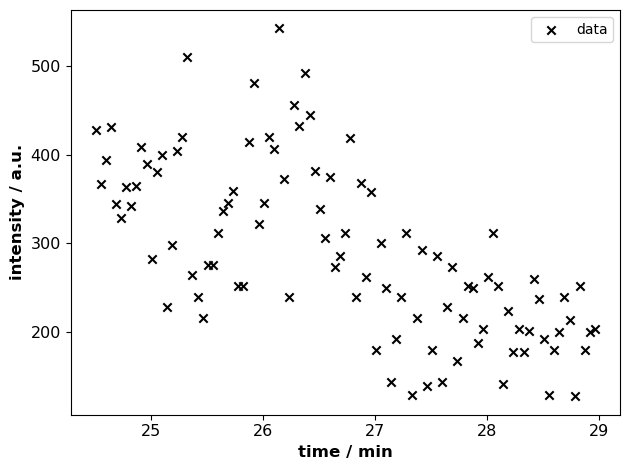

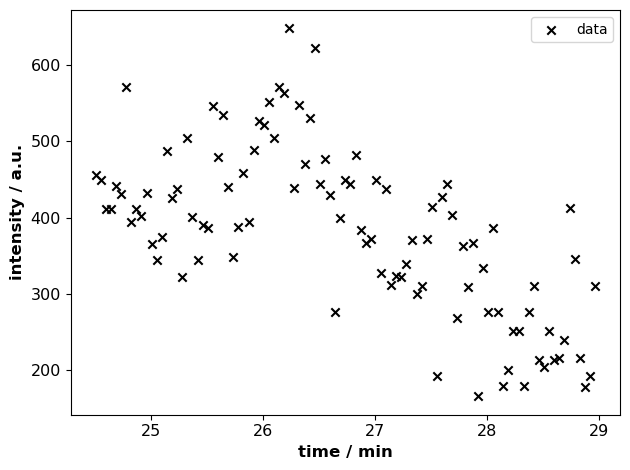

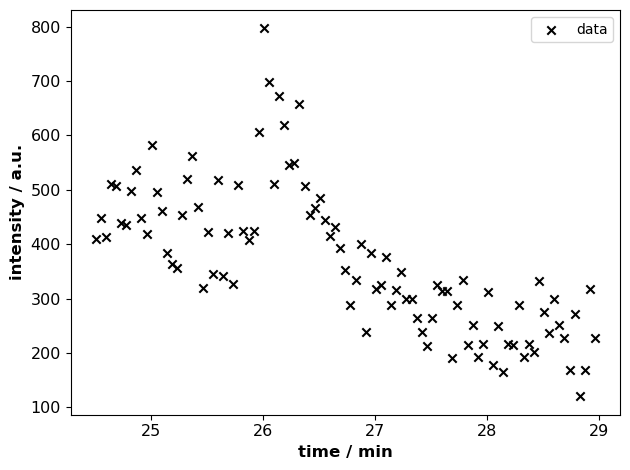

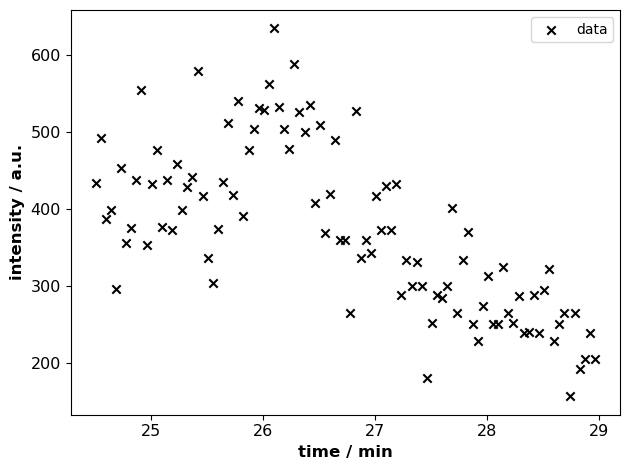

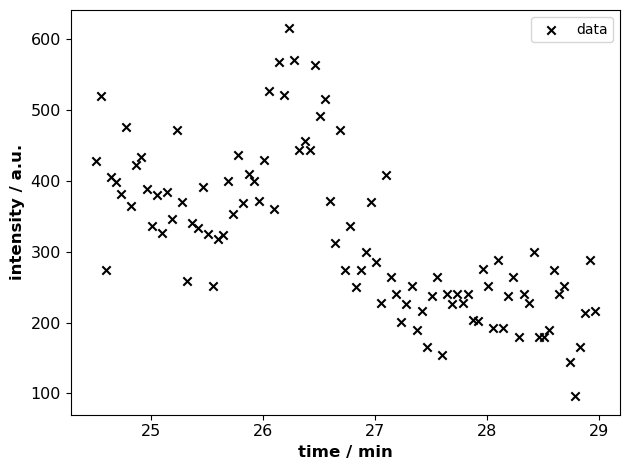

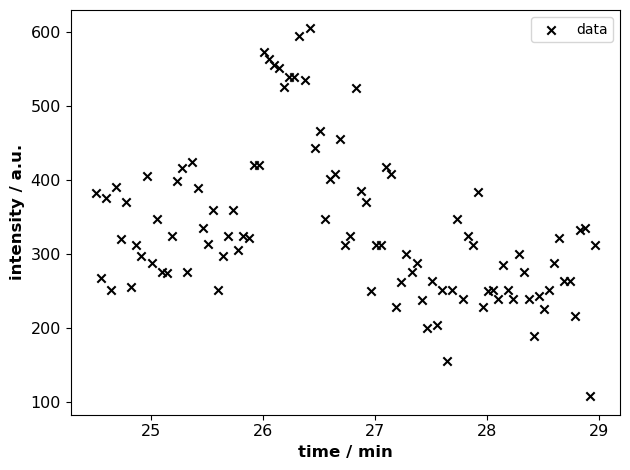

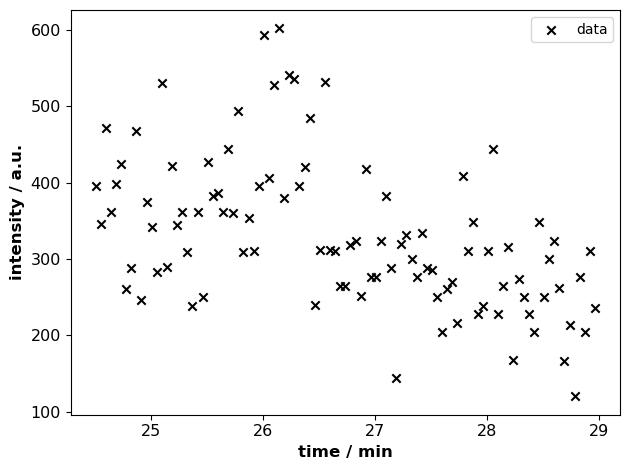

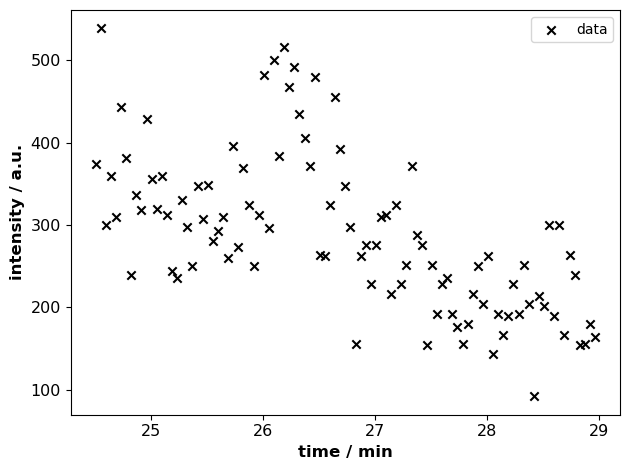

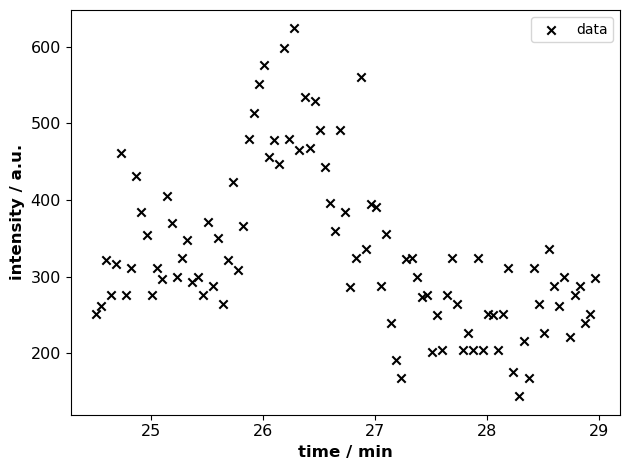

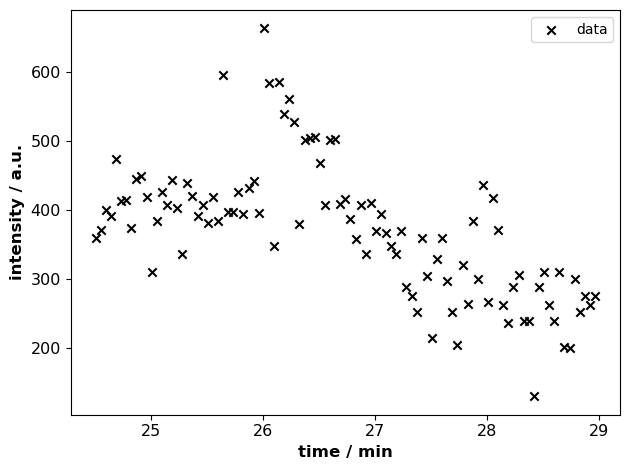

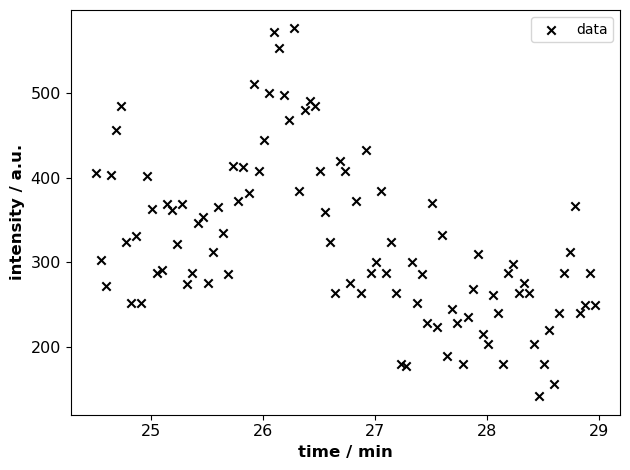

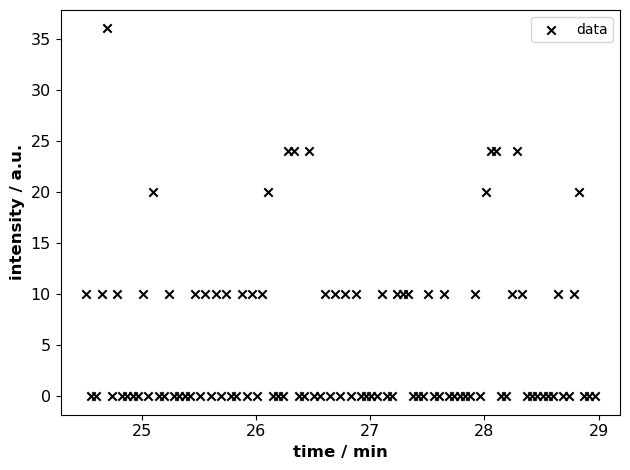

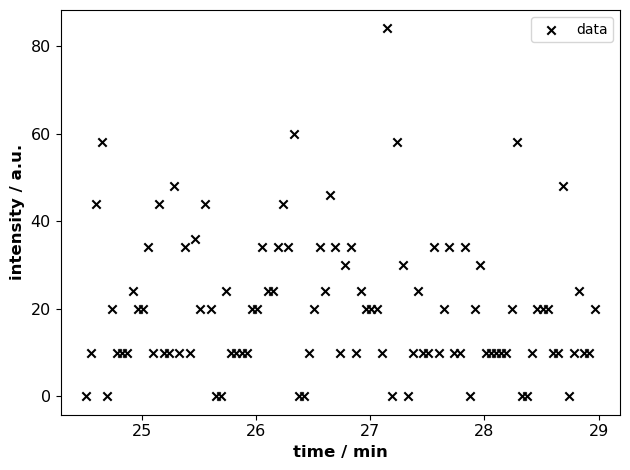

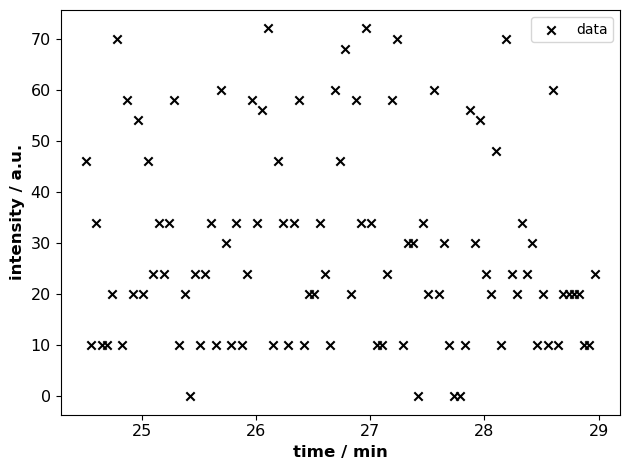

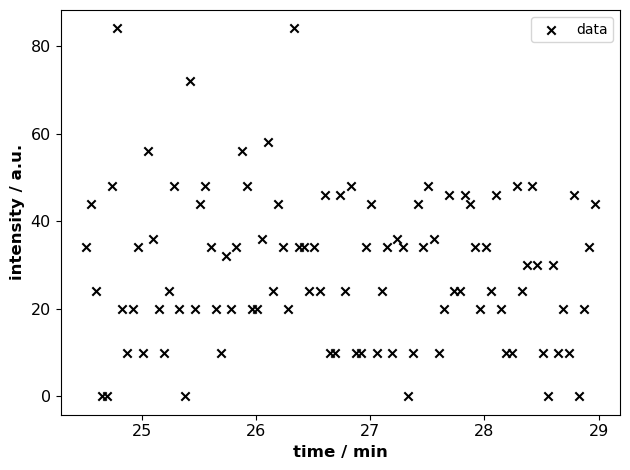

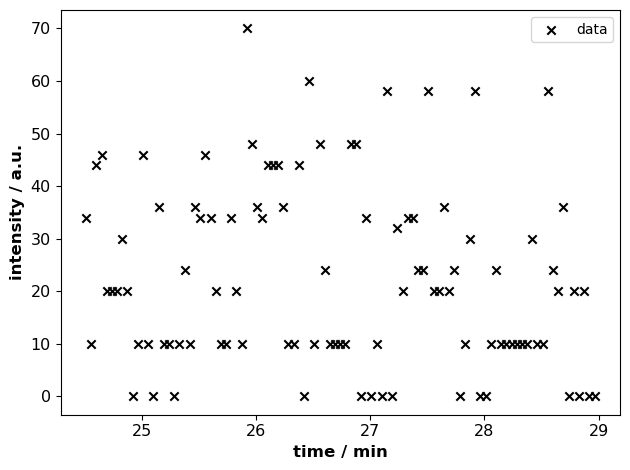

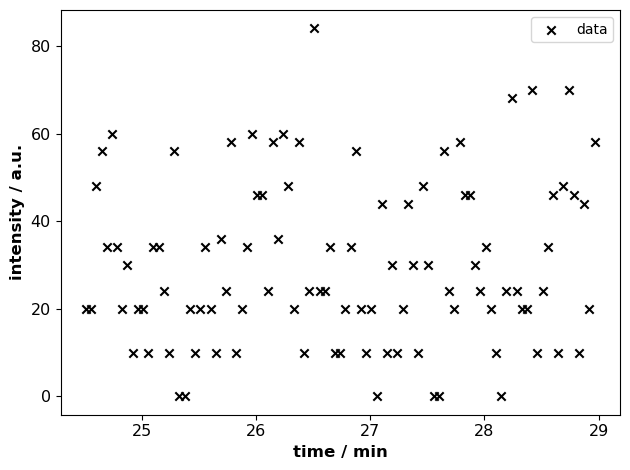

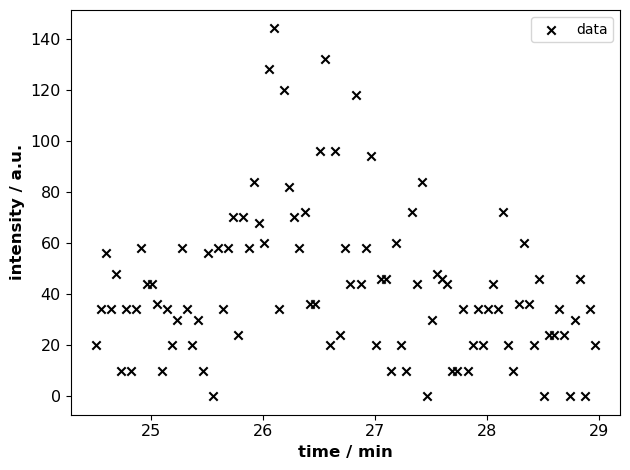

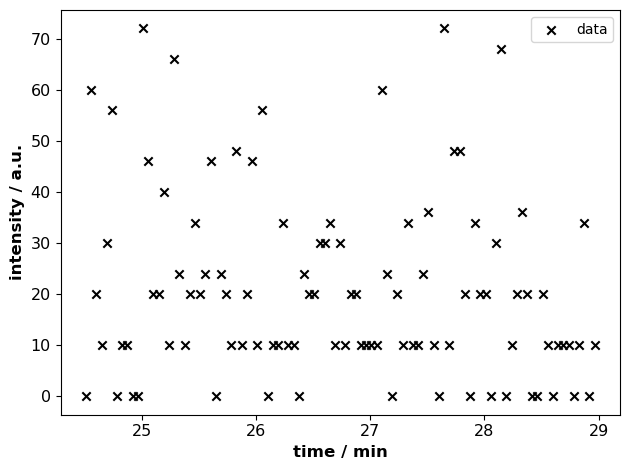

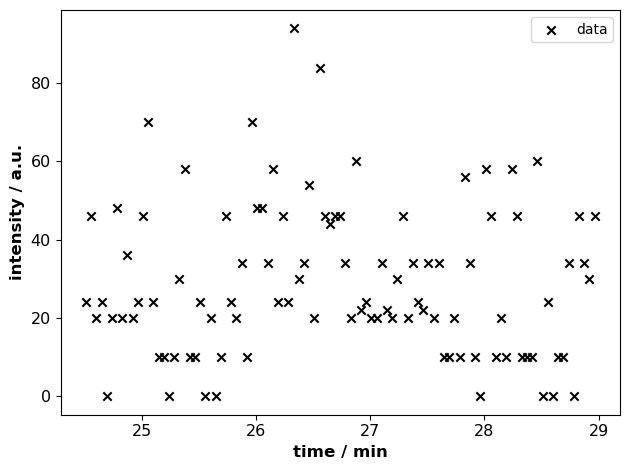

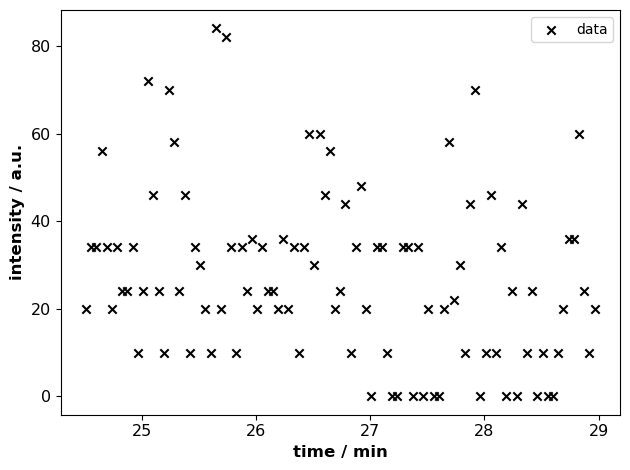

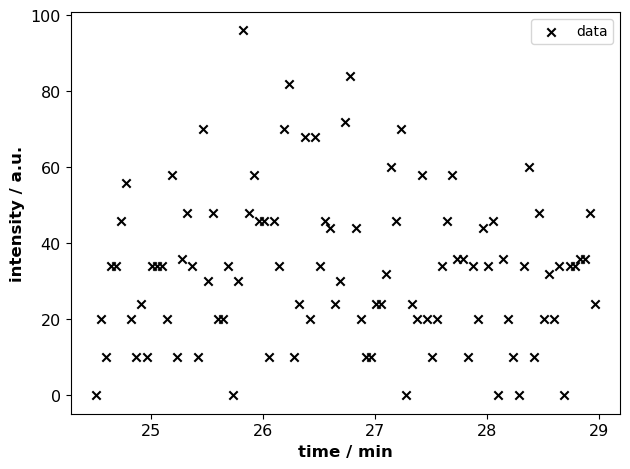

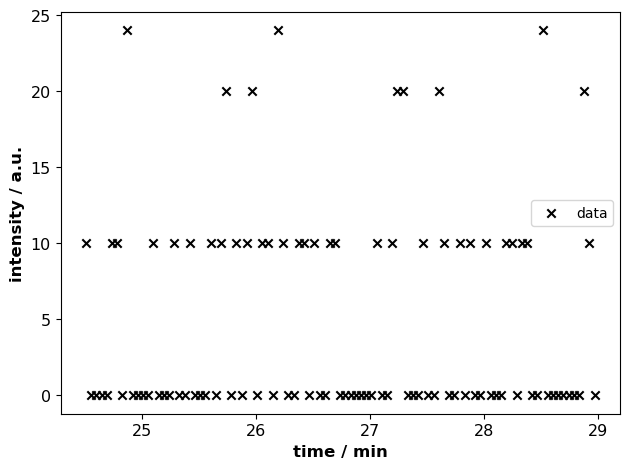

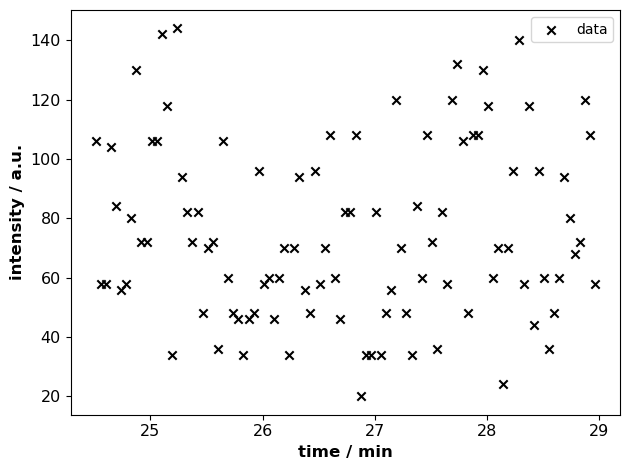

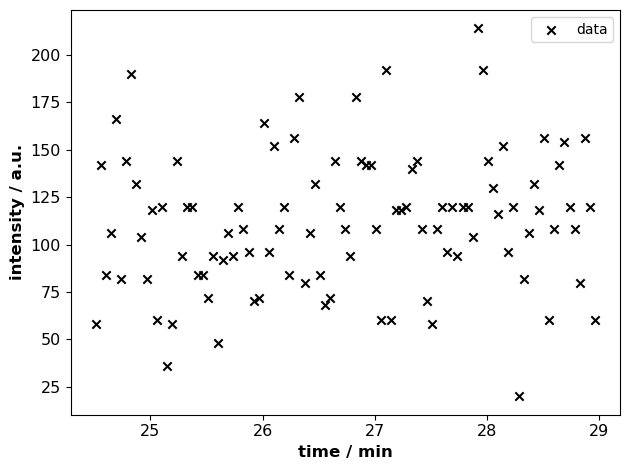

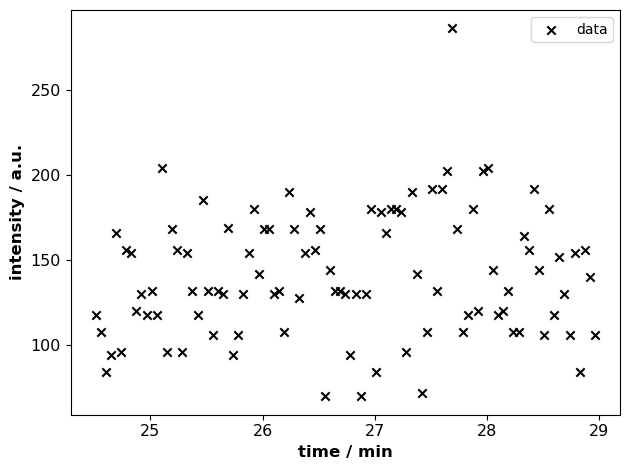

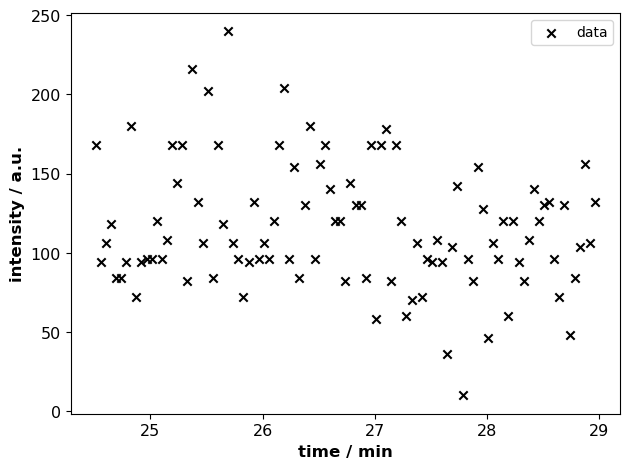

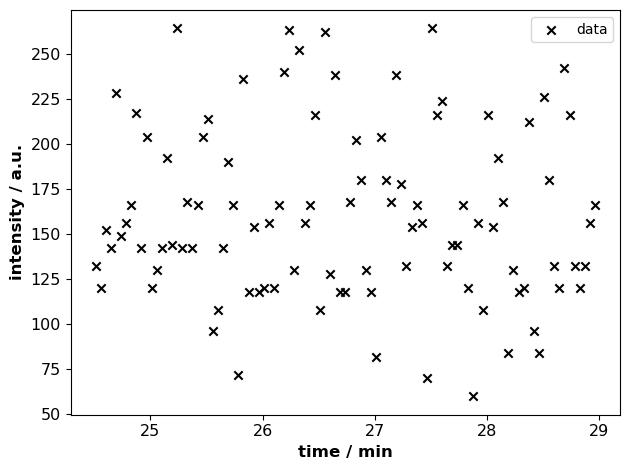

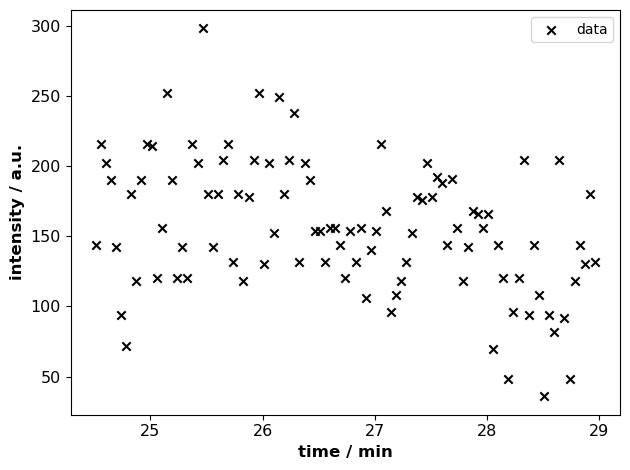

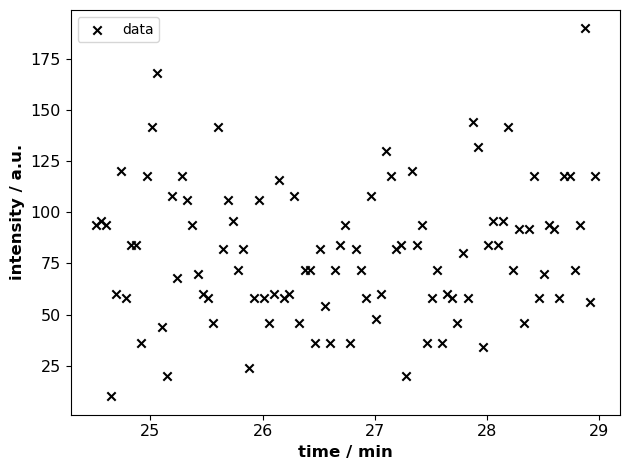

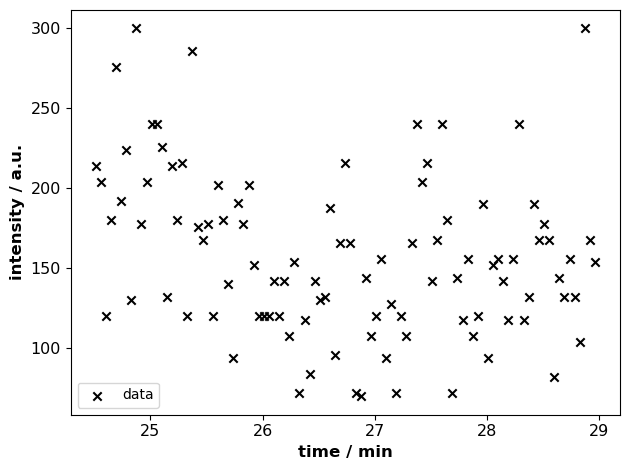

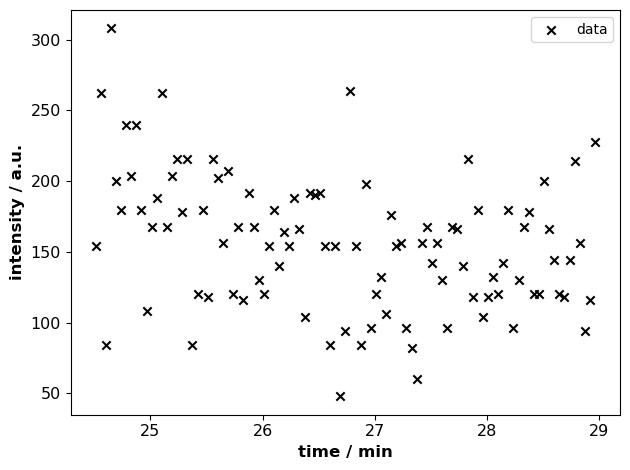

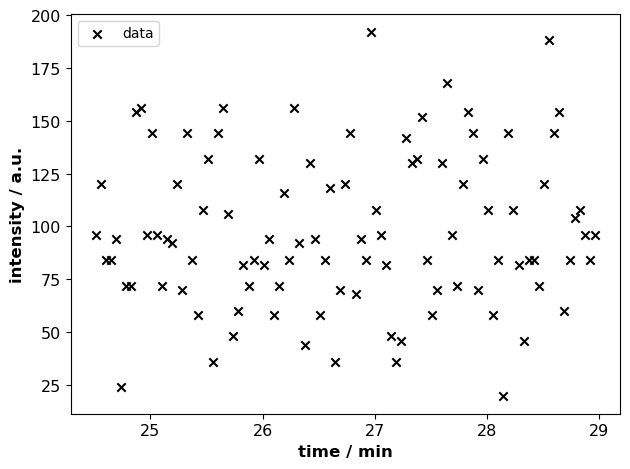

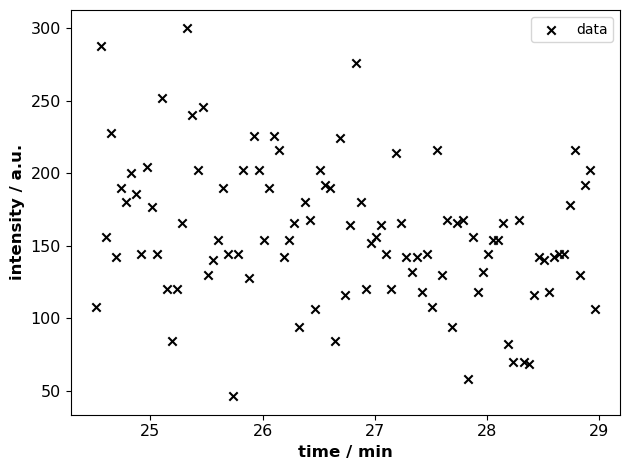

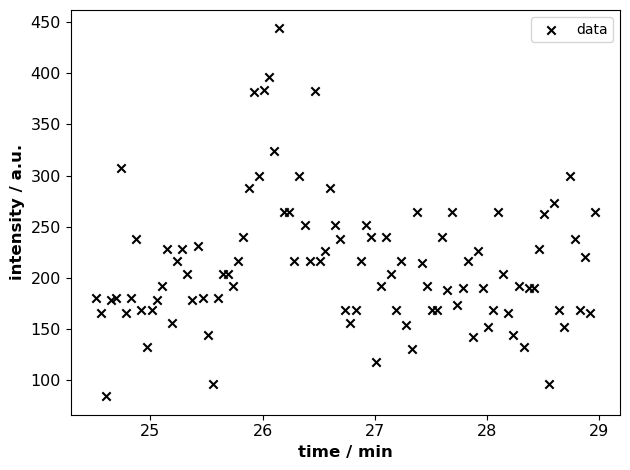

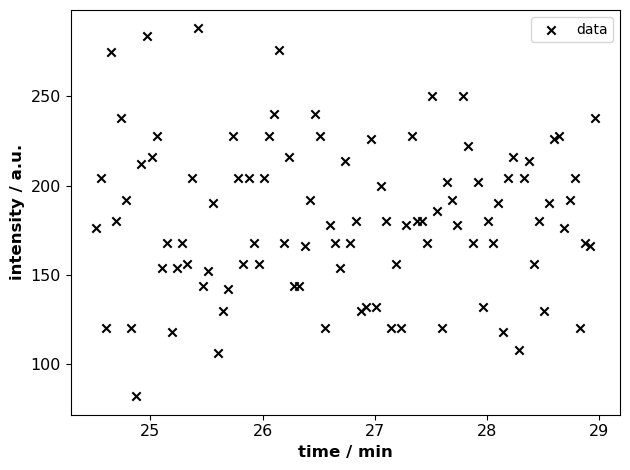

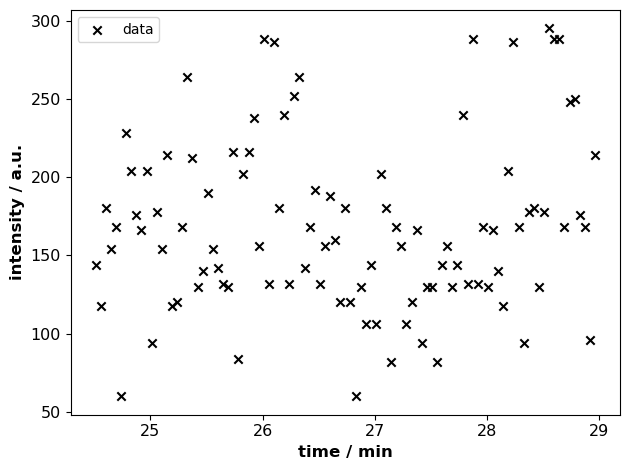

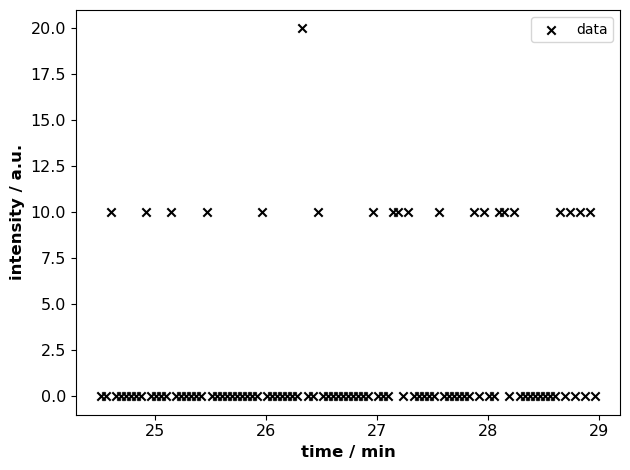

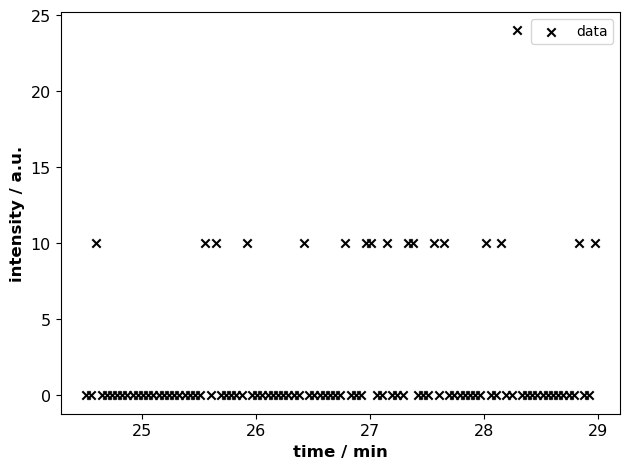

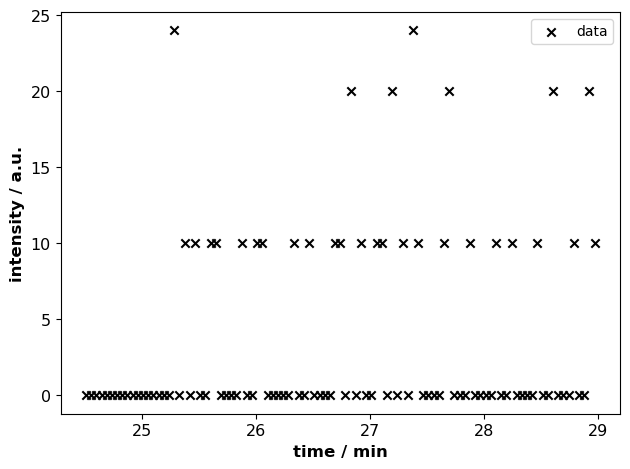

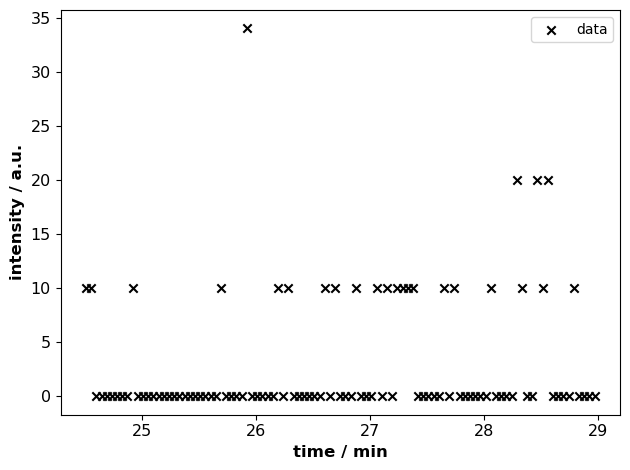

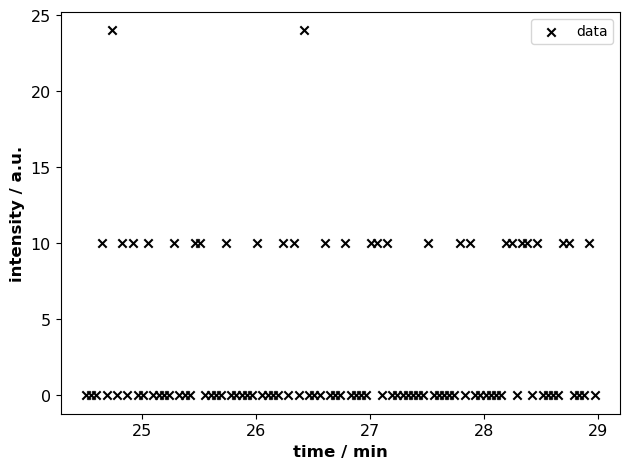

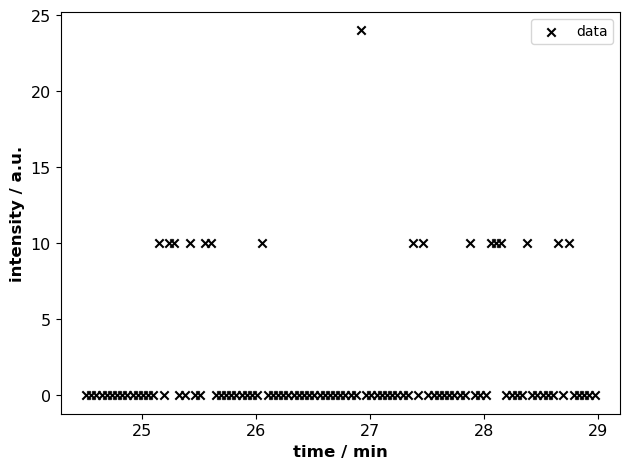

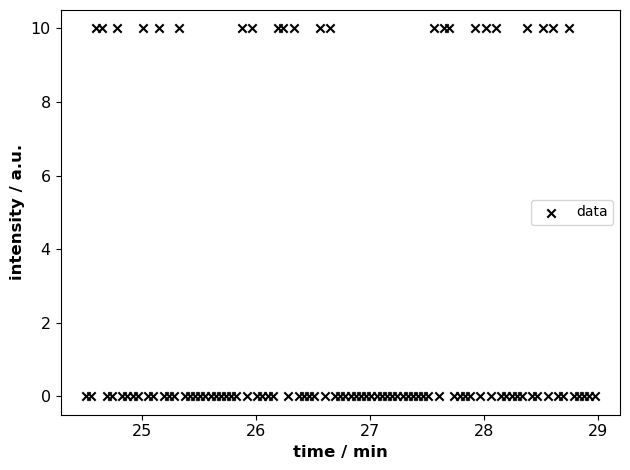

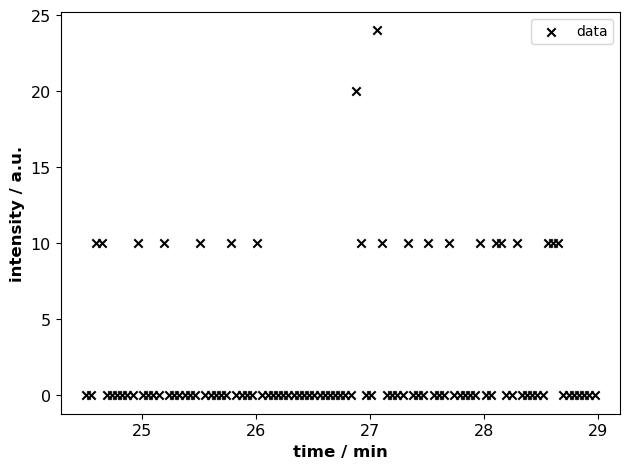

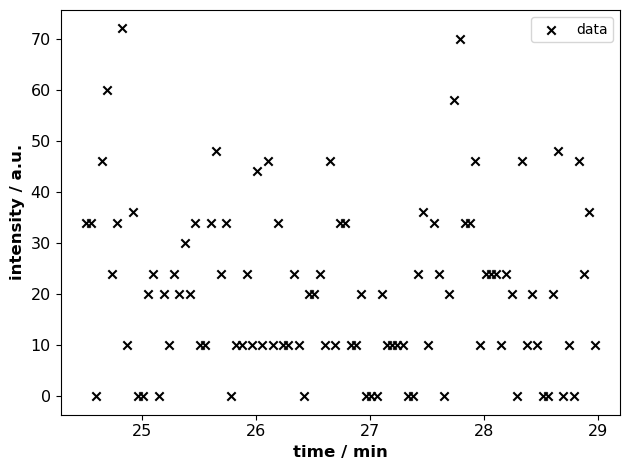

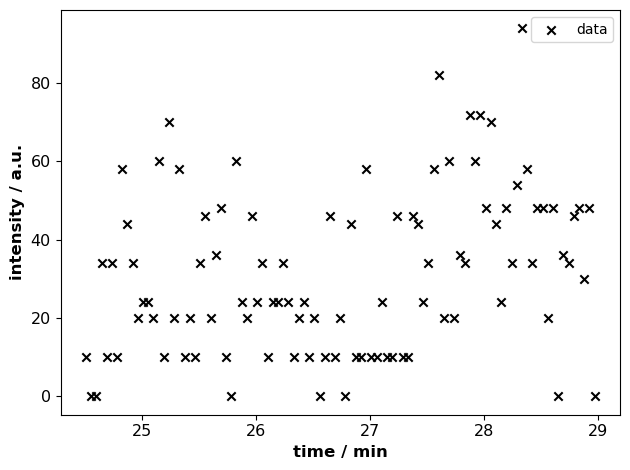

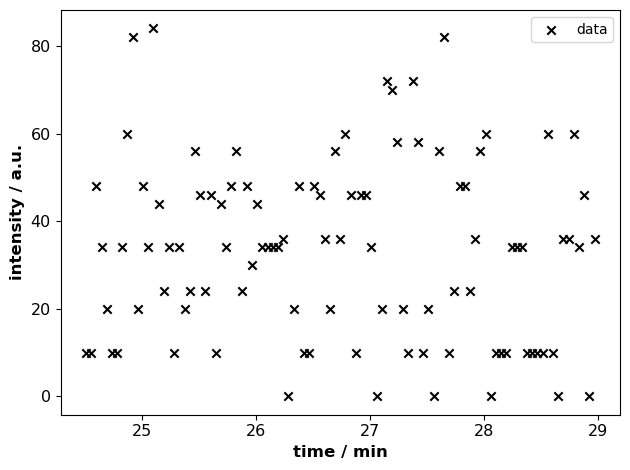

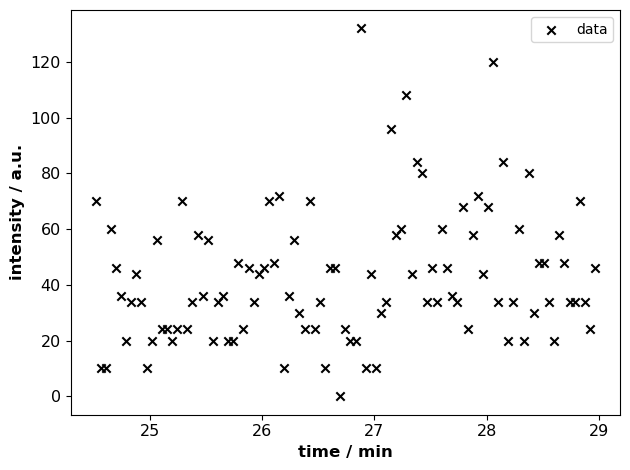

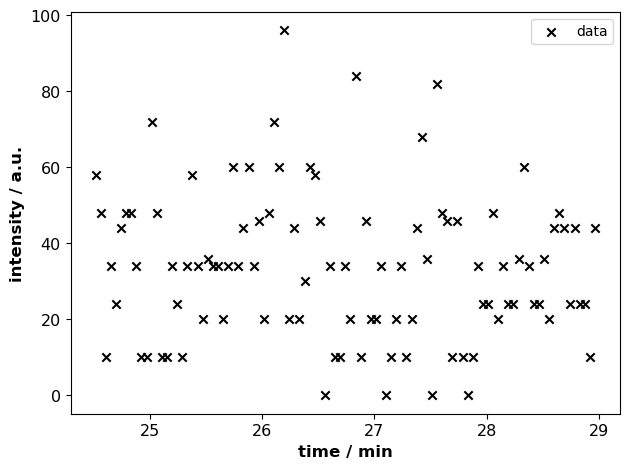

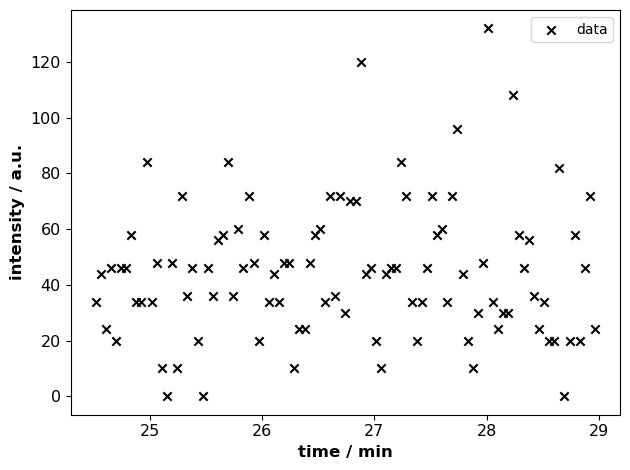

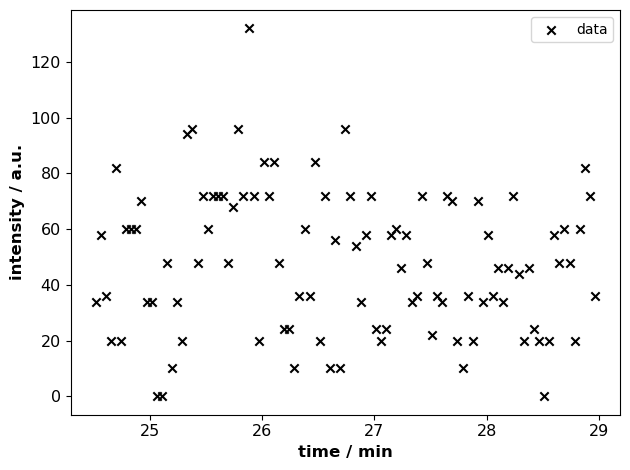

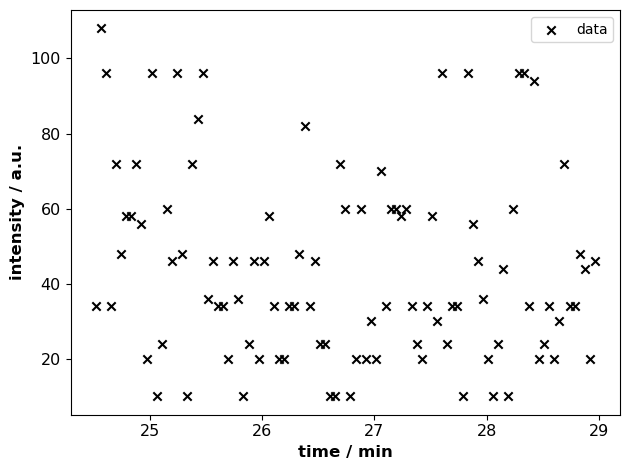

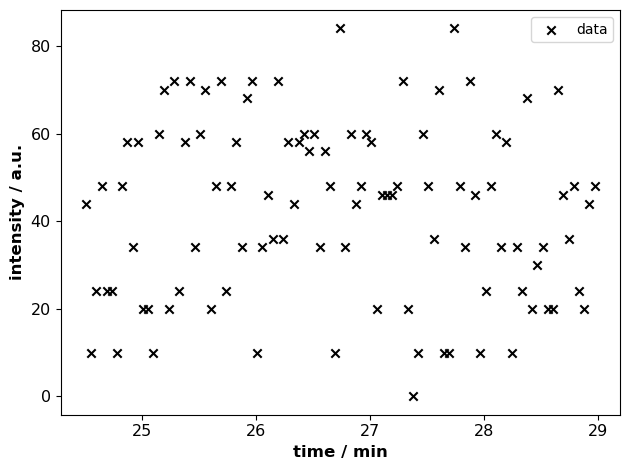

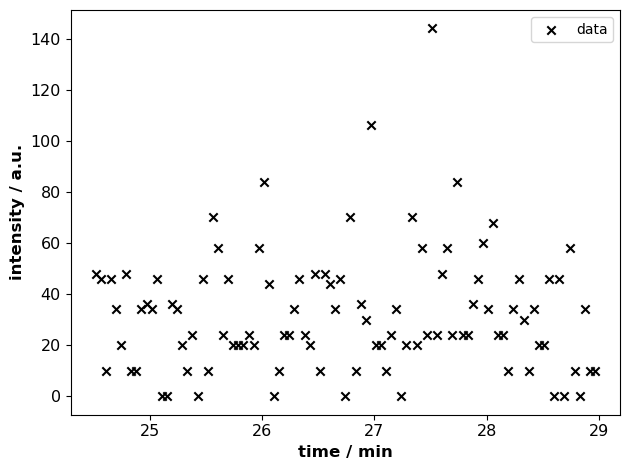

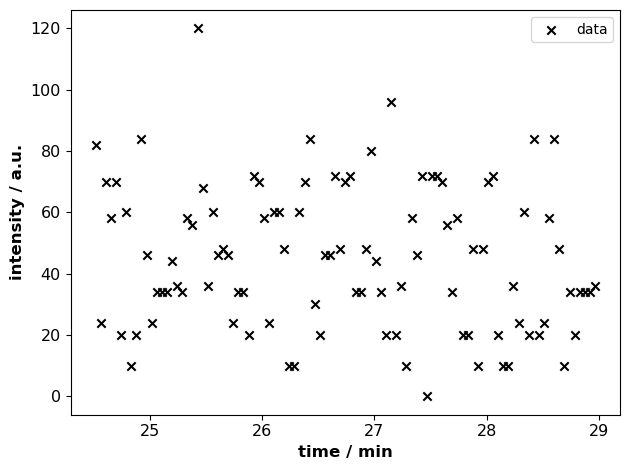

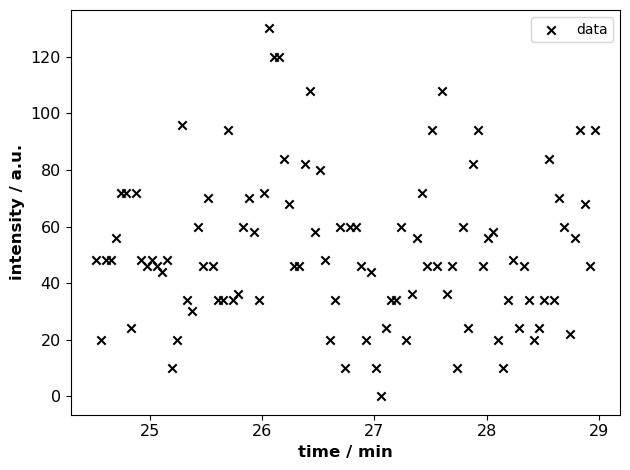

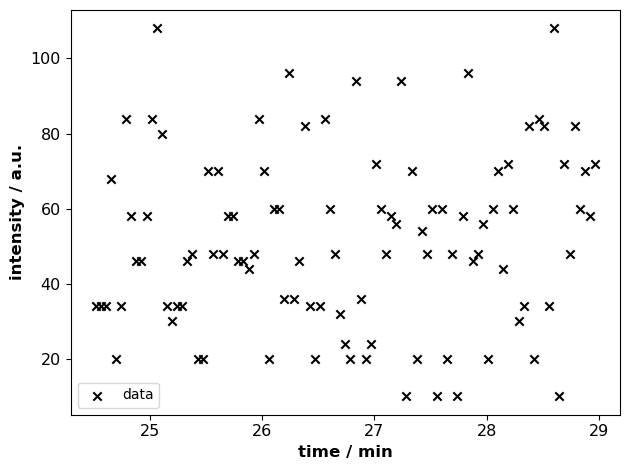

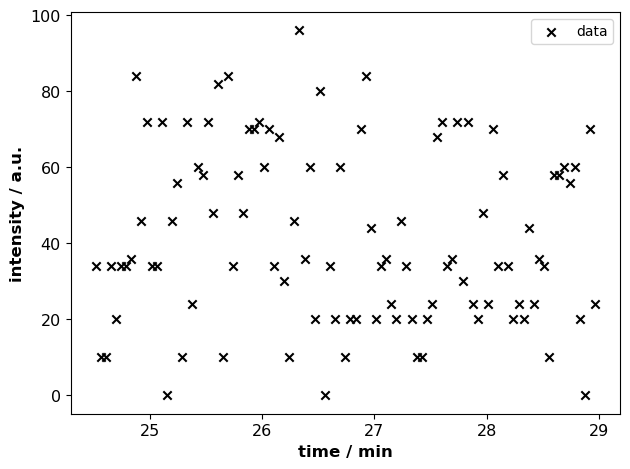

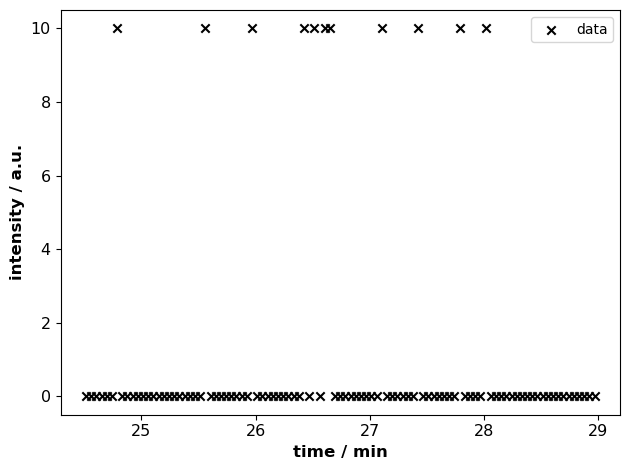

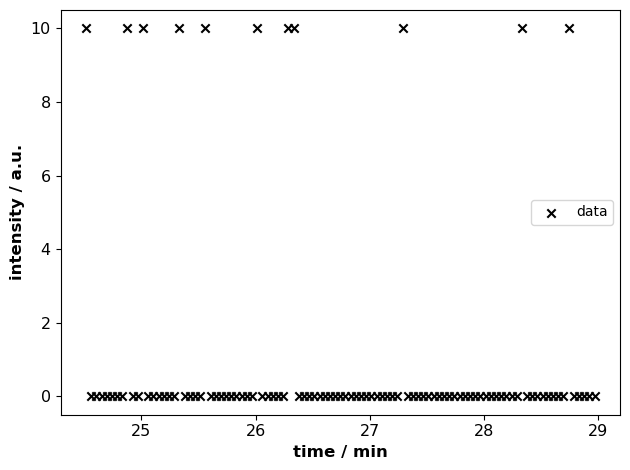

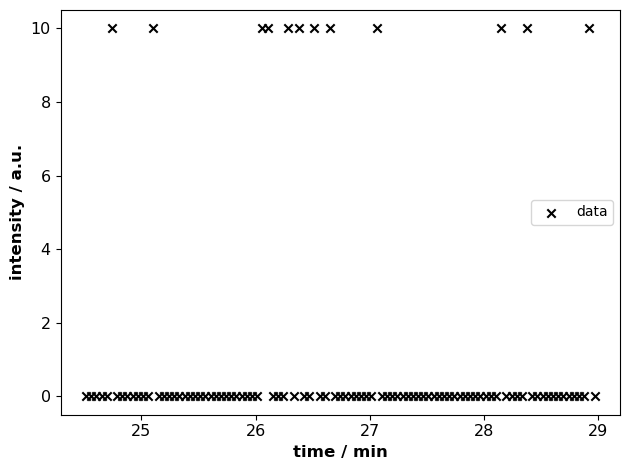

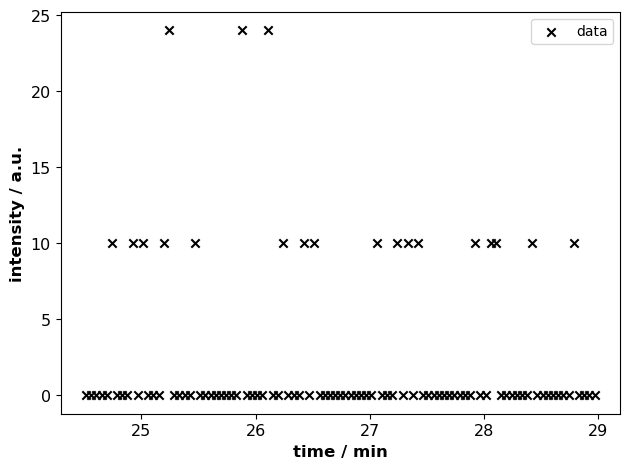

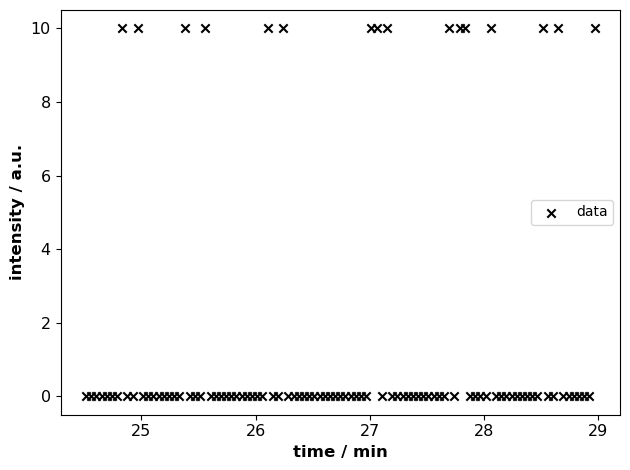

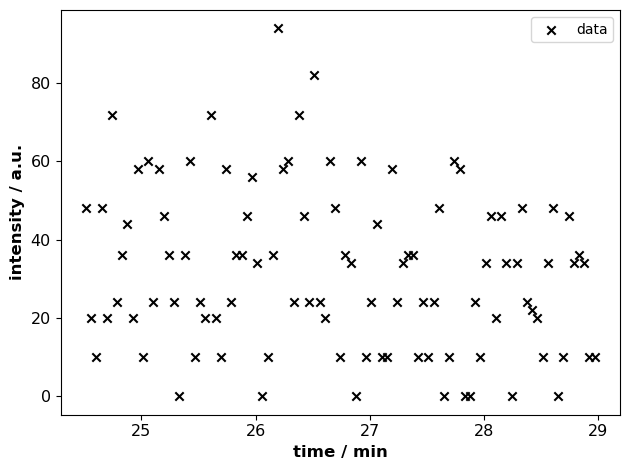

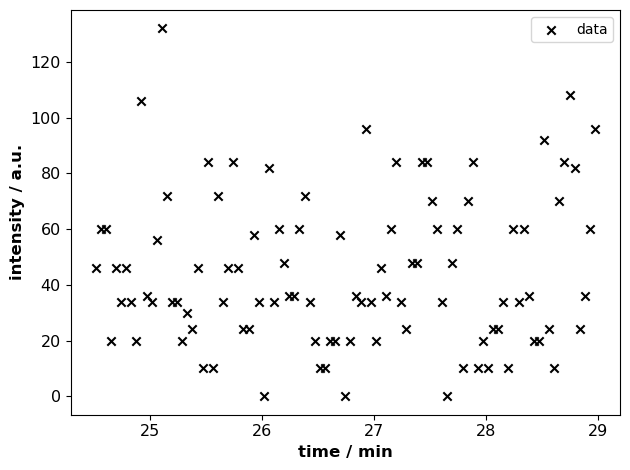

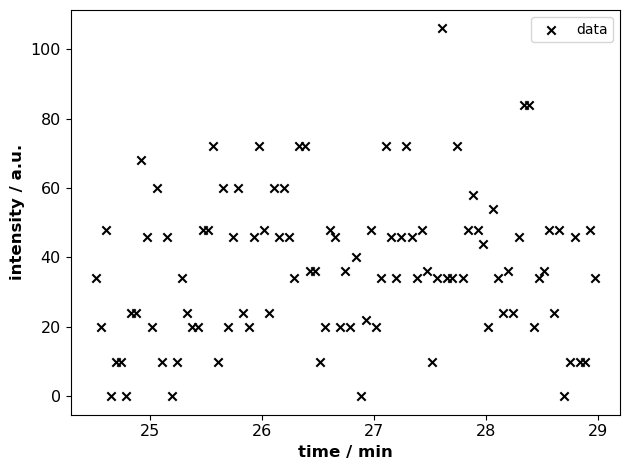

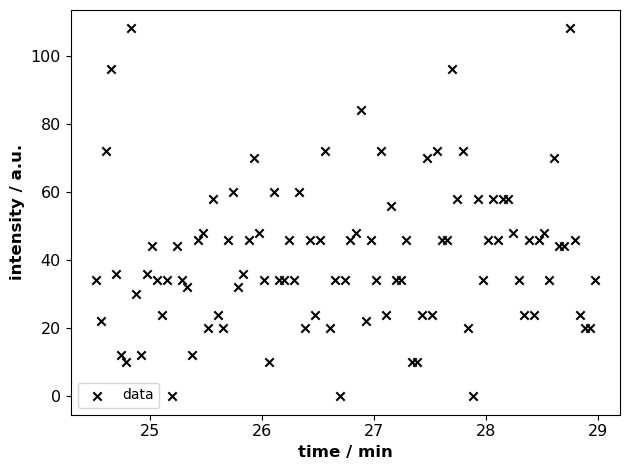

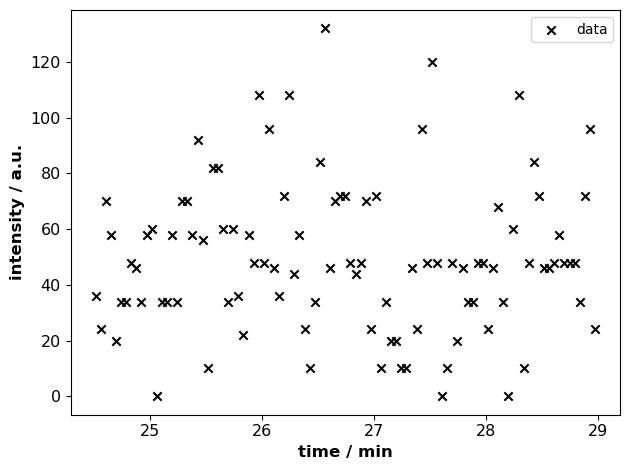

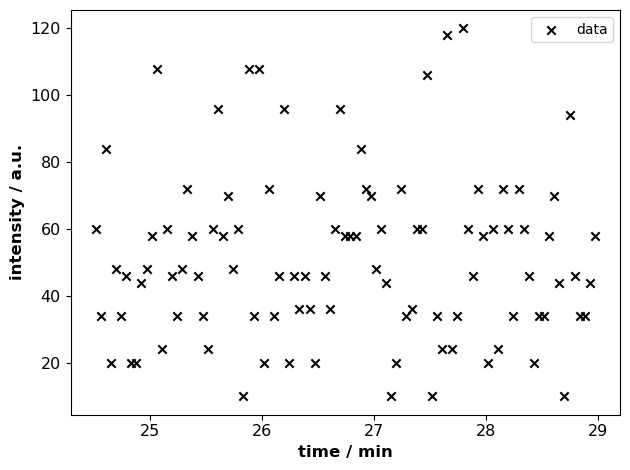

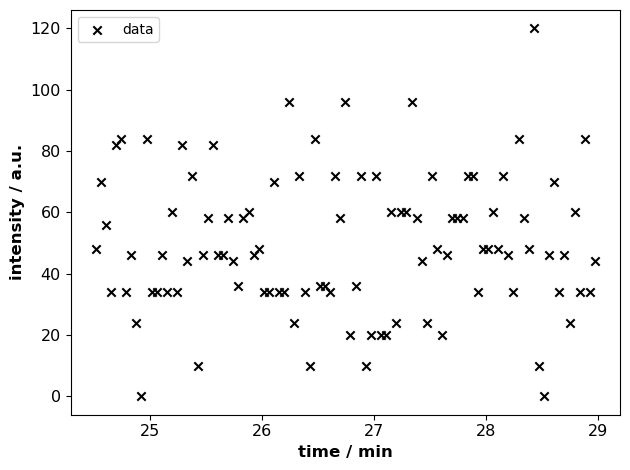

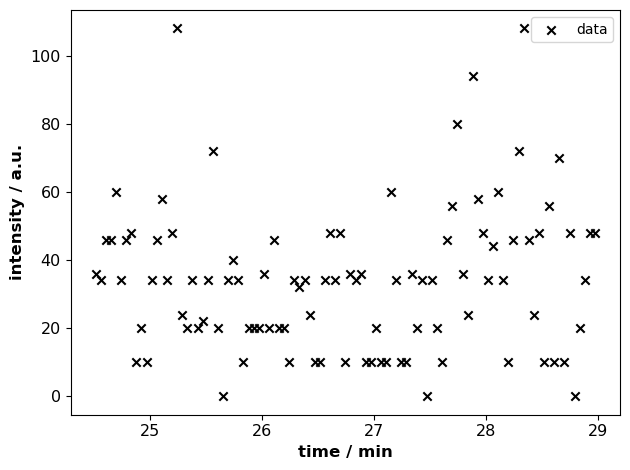

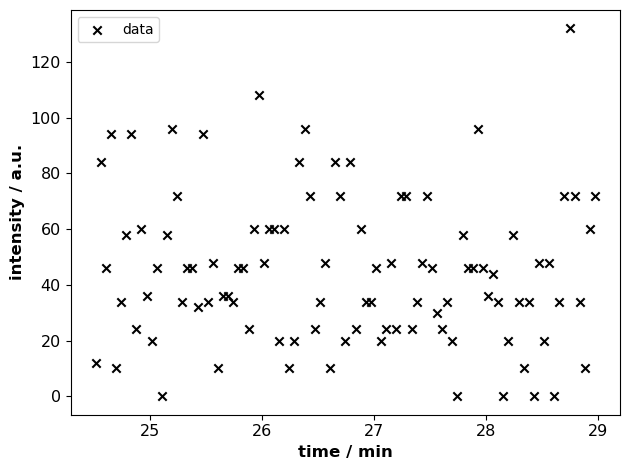

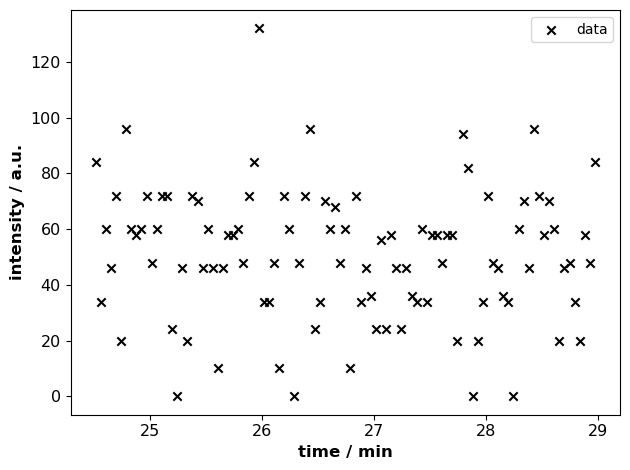

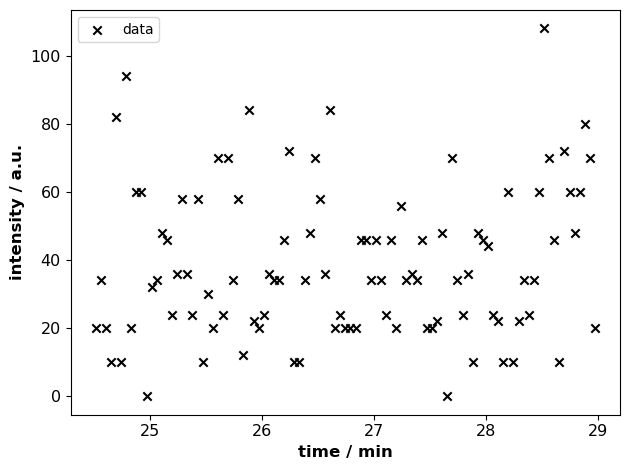

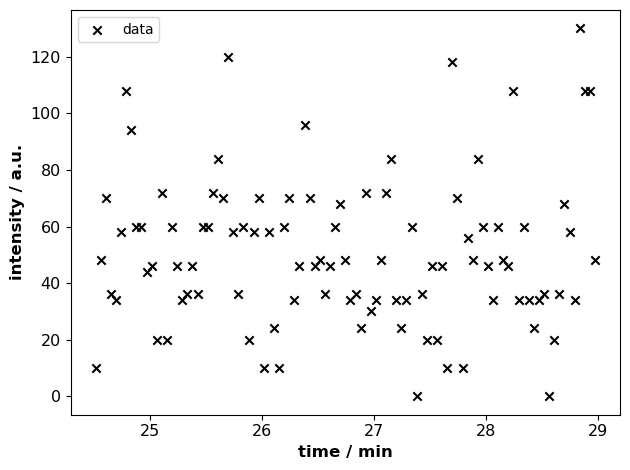

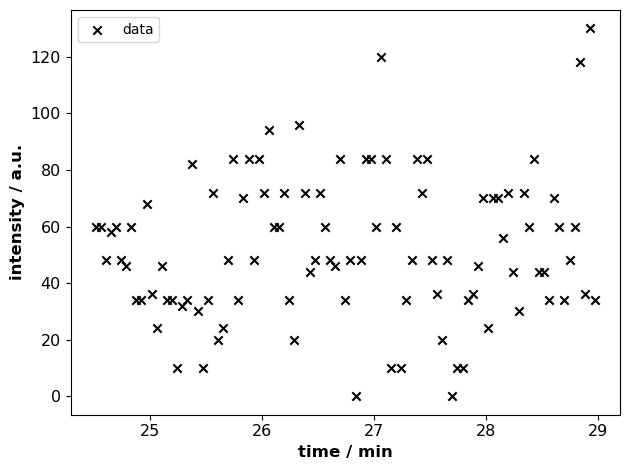

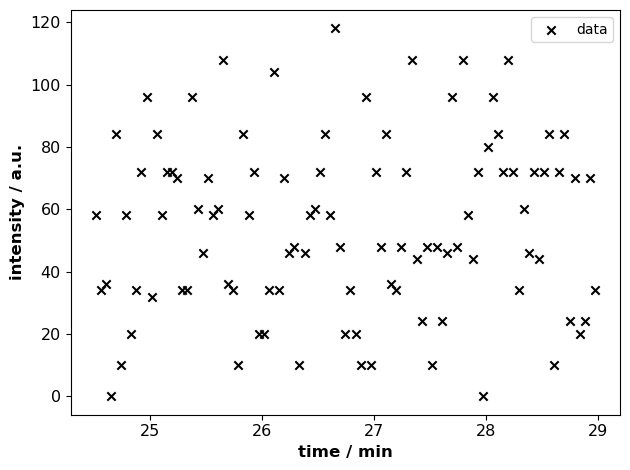

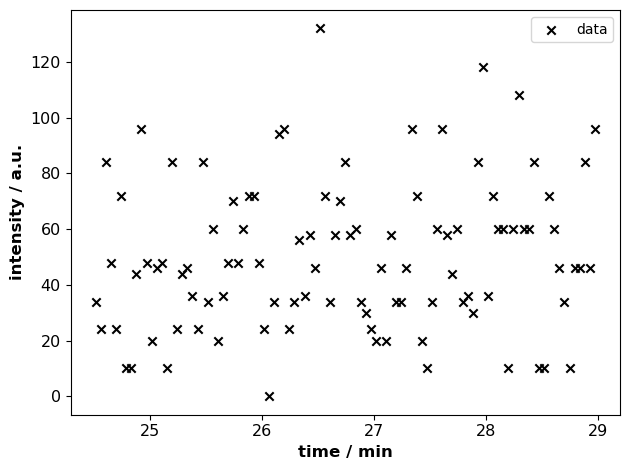

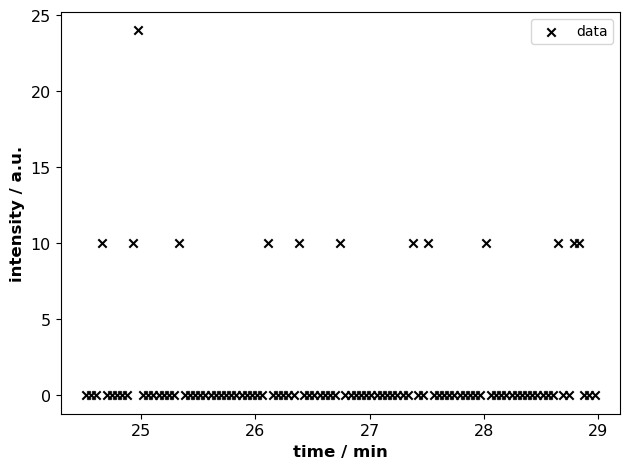

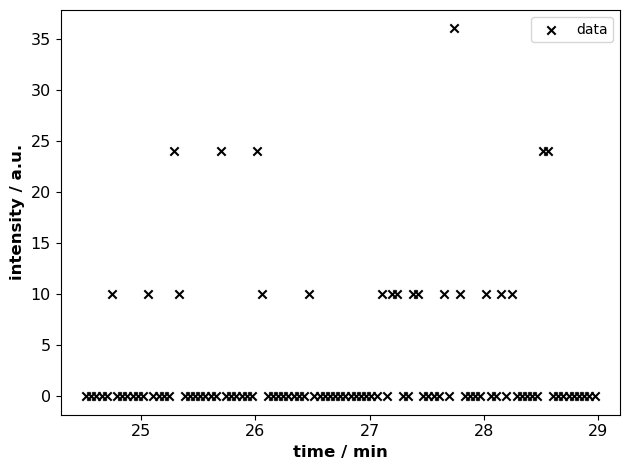

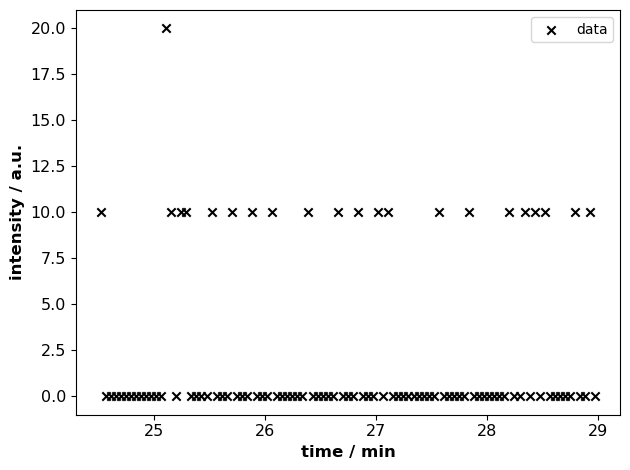

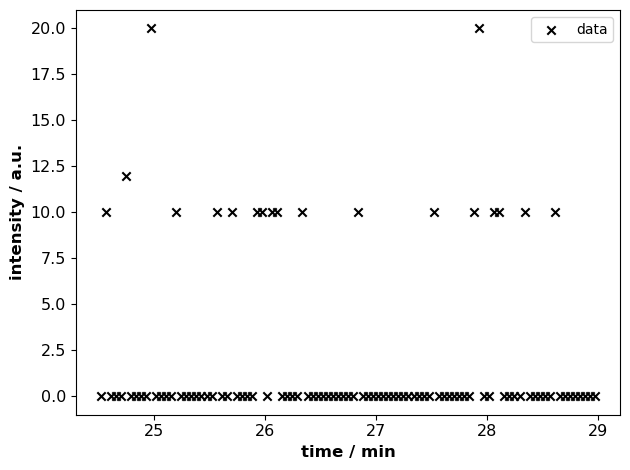

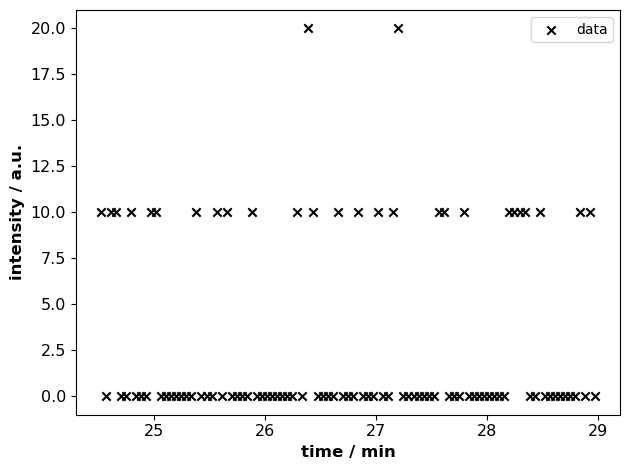

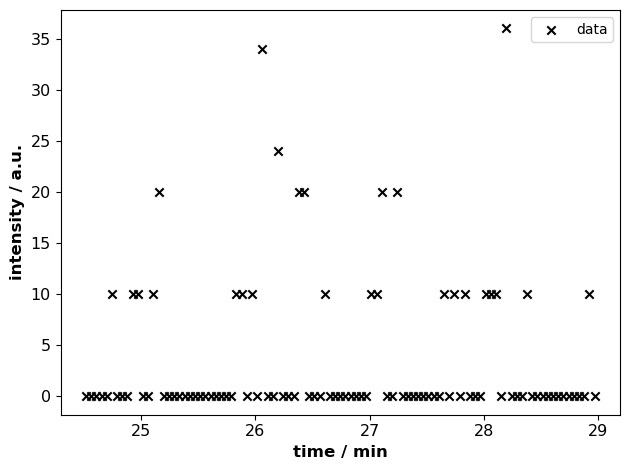

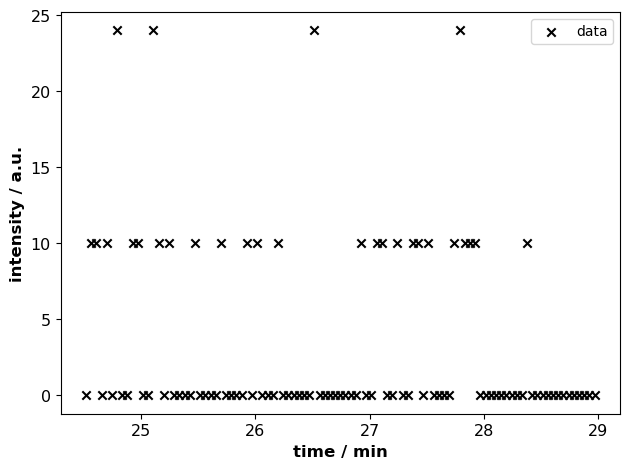

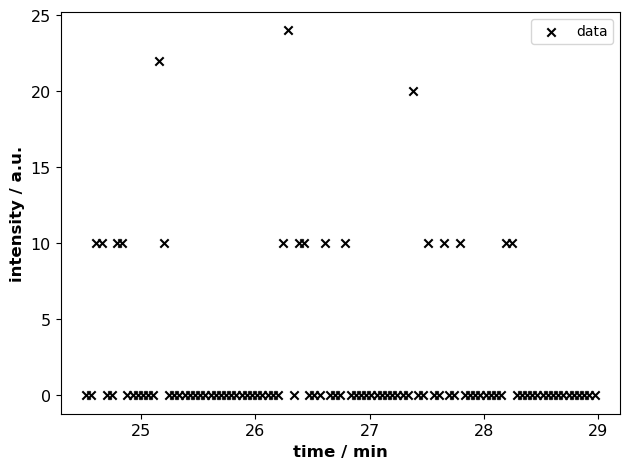

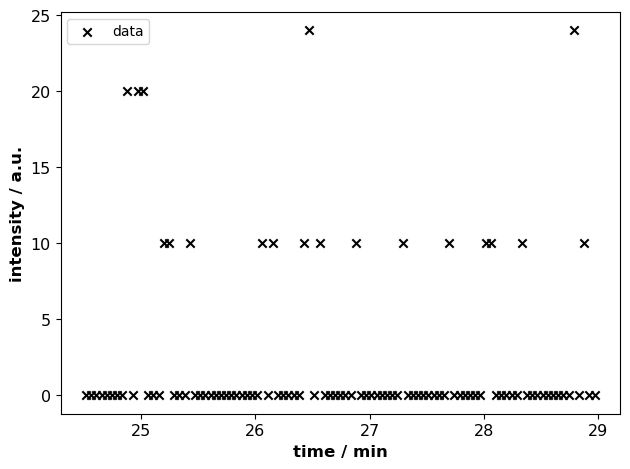

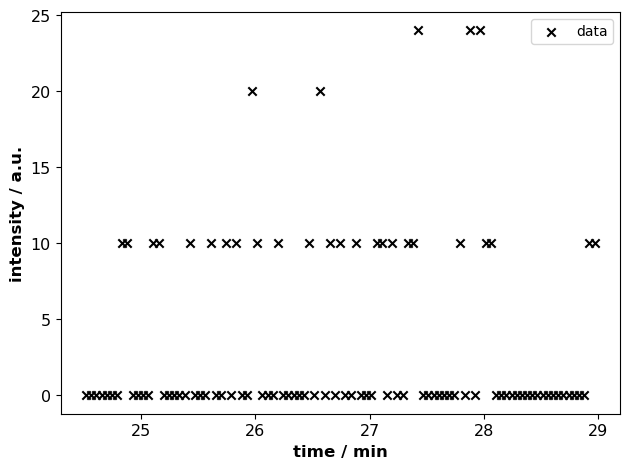

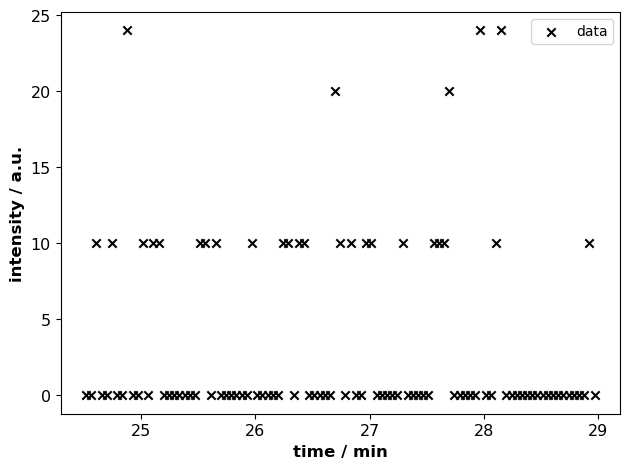

In [44]:
# TODO: add exception for double peaks with regards to data storage, lest summary df will break due to mean, mean[1] etc. -> does not matter for test with His110
# parameters for pre-filtering: is there even a peak?
est_width = 1
# prepare dictionary to save all idata objects
idata_dict = {"idata": {}}
# prepare dictionary to save duration of specific sections
time_dict = {"model_building": {}, "sampling": {}, "posterior_predictive_sampling": {}}
# prepare dictionary to save initial guesses for prior parameters
guess_dict = {"slope_guess": {}, "intercept_guess": {}, "noise_width_guess": {}}

# prepare DataFrame for joint peak data report
df_summary = pandas.DataFrame()

for fragment in user_info.keys():
    print(f"Starting with {fragment}")
    # iterate over all mass traces of a fragment
    for masstrace in range(len(user_info[fragment]['MS_info'])):
        print(f"Starting with {user_info[fragment]['MS_info'][masstrace][3]}")
        # iterate over all acquisitions within the batch
        for acquisition in acquisitions:
            # TODO: brauche ich Listen? Bei model braucht man array; außerdem muss "time" frei bleiben für das Paket
            print((fr"./His110 test data/{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}_time.npy"))
            time_np = np.fromfile(fr"./His110 test data/{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}_time.npy")
            intensity = np.fromfile(fr"./His110 test data/{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}_intensity.npy")

            # select lowest third of all data points as noise -> noise_tuple
            intensity_tuple = list(enumerate(intensity))
            intensity_tuple.sort(key=lambda x: x[1])
            noise_range = int(np.round(1/3 * len(intensity), decimals=0))
            noise_tuple = intensity_tuple[:noise_range]
            # sort noise_tuple by time, then use the first and last data points for estimating starting values for the priors of noise width and the slope and intercept of baseline
            noise_tuple.sort(key=lambda x: x[0])
            slope_guess = (np.mean([noise_tuple[n][1] for n in range(len(noise_tuple)-5, len(noise_tuple))])-np.mean([noise_tuple[n][1] for n in range(5)]))/(time_np[-1] - time_np[0])
            intercept_guess = np.mean([noise_tuple[n][1] for n in range(5)])
            noise_width_guess = np.max([noise_tuple[n][1] for n in range(len(noise_tuple))]) - np.min([noise_tuple[n][1] for n in range(len(noise_tuple))])
            guess_dict["slope_guess"][f"{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}"] = slope_guess
            guess_dict["intercept_guess"][f"{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}"] = intercept_guess
            guess_dict["noise_width_guess"][f"{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}"] = noise_width_guess

            # pre-fit tests for peaks to save computation time (optional)
            # find potential peaks with scipy
            peaks,_ = scipy.signal.find_peaks(intensity)
            peak_candidates = []
            for peak in peaks:
                # test 
                if user_info[fragment]['time'][2] - est_width <= time_np[peak] <= user_info[fragment]['time'][2] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
                    peak_candidates.append(peak)
            # in case of a double peak, test second retention time, too
            if user_info[fragment]['double_peak'] == True:
                for peak in peaks:
                    if user_info[fragment]['time'][3] - est_width <= time_np[peak] <= user_info[fragment]['time'][3] + est_width and intensity[peak]/noise_width_guess > 5 and intensity[peak-1]/noise_width_guess > 2 and intensity[peak+1]/noise_width_guess > 2:
                        peak_candidates.append(peak)

            if not peak_candidates:
                print(f"For mass trace {fragment}, no valid peak was detected.")
                # plot the data to be able to check if peak detection was correct or not
                fig, ax = pyplot.subplots()
                ax.scatter(time_np, intensity, marker="x", color="black", label="data")
                pyplot.legend()
                ax.set_xlabel("time / min", fontsize=12, fontweight="bold")
                ax.set_ylabel("intensity / a.u.", fontsize=12, fontweight="bold")
                pyplot.xticks(size=11.5)
                pyplot.yticks(size=11.5)
                pyplot.tight_layout()
                pyplot.savefig(fr"./230418_Pipeline_test_His110/No_Peak_{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}.png")
                pyplot.savefig(fr"./230418_Pipeline_test_His110/No_Peak_{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}.svg", format="svg")
                continue

            # create model with the above guesses as starting values for priors
            # TODO: double peak und skew berücksichtigen
            start = time.time()
            with pm.Model() as pmodel:
                # priors plus error handling in case of mathematically impermissible values
                if intercept_guess == 0:
                    baseline_intercept = pm.Normal("baseline_intercept", intercept_guess, 20)
                else:
                    baseline_intercept = pm.Normal("baseline_intercept", intercept_guess, intercept_guess / 2)
                baseline_slope = pm.Normal("baseline_slope", slope_guess, np.abs(slope_guess*2)+1)
                baseline = pm.Deterministic("baseline", baseline_intercept + baseline_slope * time_np)
                # since log(0) leads to -inf, this case is handled by setting noise_width_guess to 10
                if noise_width_guess > 0:
                    noise = pm.LogNormal("noise", np.log(noise_width_guess), 1)
                elif noise_width_guess == 0:
                    noise = pm.LogNormal("noise", np.log(10), 1)
                mean = pm.Normal("mean", np.mean(time_np[[0, -1]]), np.ptp(time_np) / 2)
                std = pm.HalfNormal("std", np.ptp(time_np) / 3)
                height = pm.HalfNormal("height", 0.95 * np.max(intensity))
                area = pm.Deterministic("area", height/(1 / (std * np.sqrt(2 * np.pi))))
                sn = pm.Deterministic("sn", height/noise)
                # posterior
                y = baseline + height * pt.exp(-0.5 * ((time_np - mean) / std)**2)
                y = pm.Deterministic("y", y)

                # likelihood (auf der y-Achse liegende Normalverteilung um Datenpunkte, entspricht hier Normalverteilung um Wert mit Standardabweichung = noise)
                L = pm.Normal("L", mu=y, sigma=noise, observed=intensity)
            time1 = time.time() - start
            
            # sample the model
            start = time.time()
            with pmodel:
                idata = pm.sample_prior_predictive()
                idata.extend(pm.sample(draws=2000, tune=2000))
            time2 = time.time() - start

            # post-fit checks
            # check for convergence, i.e. r_hat <= 1.05
            if any(list(az.summary(idata).loc[:,"r_hat"])) > 1.05:
                # decide whether to discard signal or sample with more tune samples based on size of sigma parameter of normal distribution (std) and on the relative sizes of standard deviations of area and heigt
                if az.summary(idata).loc["std",:]["mean"] <= 0.1 or az.summary(idata).loc["area",:]["sd"] > az.summary(idata).loc["area",:]["mean"] * 0.2 or az.summary(idata).loc["height",:]["sd"] > az.summary(idata).loc["height",:]["mean"] * 0.2:
                    # post-fit check failed
                    idata_dict["idata"][f"{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}"] = idata
                    # add NaN values to summary DataFrame
                    df = pandas.DataFrame({"baseline_intercept":[np.nan],"baseline_slope":[np.nan], "mean":[np.nan], "noise":[np.nan], "std":[np.nan], "area":[np.nan], "height":[np.nan], "sn":[np.nan]})
                    df_summary = pandas.concat([df_summary,df])
                    continue
                else:
                    # r_hat failed but rest of post-fit check passed
                    # sample again with more tune samples to possibly reach convergence yet
                    with pmodel:
                        idata2 = pm.sample_prior_predictive()
                        idata2.extend(pm.sample(draws=2000, tune=4000))
                    # if still no convergence, kick it
                    if any(list(az.summary(idata2).loc[:,"r_hat"])) > 1.05:
                        idata_dict["idata"][f"{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}"] = idata2
                        # add NaN values to summary DataFrame
                        df = pandas.DataFrame({"baseline_intercept":[np.nan],"baseline_slope":[np.nan], "mean":[np.nan], "noise":[np.nan], "std":[np.nan], "area":[np.nan], "height":[np.nan], "sn":[np.nan]})
                        df_summary = pandas.concat([df_summary,df])
                        continue
                    # if results still don't meet plausibility/quality criteria, kick it
                    elif az.summary(idata2).loc["std",:]["mean"] <= 0.1 or az.summary(idata2).loc["area",:]["sd"] > az.summary(idata2).loc["area",:]["mean"] * 0.2 or az.summary(idata2).loc["height",:]["sd"] > az.summary(idata2).loc["height",:]["mean"] * 0.2:
                        idata_dict["idata"][f"{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}"] = idata2
                        # add NaN values to summary DataFrame
                        df = pandas.DataFrame({"baseline_intercept":[np.nan],"baseline_slope":[np.nan], "mean":[np.nan], "noise":[np.nan], "std":[np.nan], "area":[np.nan], "height":[np.nan], "sn":[np.nan]})
                        df_summary = pandas.concat([df_summary,df])
                        continue
                    # if result is improved, accept new inference data and go on
                    else:
                        idata = idata2
            
            # posterior predictive sampling
            start = time.time()
            with pmodel:
                idata.extend(pm.sample_posterior_predictive(idata, return_inferencedata=True))
            time3 = time.time() - start

            # save inference data
            idata_dict["idata"][f"{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}"] = idata
            # save selected parameters for summary DataFrame
            df = az.summary(idata).loc[["baseline_intercept","baseline_slope", "mean", "noise", "std", "area", "height", "sn"],:]
            df_summary = pandas.concat([df_summary,df])
            # save every single complete summary (to be on the save side -> TODO: possibly remove this later)
            df2 = az.summary(idata)
            df2.to_excel(fr"./230418_Pipeline_test_His110/idata_summary_{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}.xlsx") 

            # save plot of posterior_predictive with 95 % HDI and original data
            fig, ax = pyplot.subplots()
            plot_density(ax=ax, x=time_np, samples=idata.posterior_predictive.L.stack(sample=("chain", "draw")).T.values, percentiles=(2.5,97.5))
            ax.scatter(time_np, intensity, marker="x", color="black", label="data")
            ax.set_xlabel("time / min", fontsize=11.5, fontweight="bold")
            ax.set_ylabel("intensity / a.u.", fontsize=11.5, fontweight="bold")
            pyplot.legend()
            pyplot.tight_layout()
            pyplot.savefig(fr"./230418_Pipeline_test_His110/No_Peak_{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}_predictive_posterior.png")
            pyplot.savefig(fr"./230418_Pipeline_test_His110/No_Peak_{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}_predictive_posterior.svg", format="svg")
            pyplot.close()

            # save plot of posterior, baseline, and original data
            fig, ax = pyplot.subplots()
            pm.gp.util.plot_gp_dist(
                ax=ax,
                x=time_np,
                samples=idata.posterior.y.stack(sample=("chain", "draw")).T.values,
            )
            ax.scatter(time_np, intensity, marker="x", color="black", label="data")
            # also plot the baseline
            x = np.array(ax.get_xlim())
            y = df.loc["baseline_intercept","mean"] + df.loc["baseline_slope","mean"] * x
            pyplot.plot(x, y)
            pyplot.legend()
            ax.set_xlabel("time / min", fontsize=12, fontweight="bold")
            ax.set_ylabel("intensity / a.u.", fontsize=12, fontweight="bold")
            pyplot.xticks(size=11.5)
            pyplot.yticks(size=11.5)
            pyplot.tight_layout()
            pyplot.savefig(fr"./230418_Pipeline_test_His110/No_Peak_{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}_posterior.png")
            pyplot.savefig(fr"./230418_Pipeline_test_His110/No_Peak_{acquisition}_{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}_posterior.svg", format="svg")
            pyplot.close()

            # save durations of certain code sections
            time_dict["model_building"][f"{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}"] = time1
            time_dict["sampling"][f"{fragment}_{user_info[fragment]['MS_info'][masstrace][3]}"] = time2
            time_dict["posterior_predictive_sampling"][f"{user_info[fragment]['MS_info'][masstrace][3]}"] = time3

guess_df = pandas.DataFrame(guess_dict)
guess_df.to_excel(fr"./230418_Pipeline_test_His110/summary_guesses.xlsx")
# summary file for peak characteristics of all fragments
df_summary.to_excel(fr"./230418_Pipeline_test_His110/summary_peak_data.xlsx")

#### Test model with skew normal distribution (exmaple: His110)

In [39]:
# Read example data
time_np = np.fromfile(fr"./His110 test data/A2_t2_1_Part2_His110_M0_m0_time.npy")
intensity_np = np.fromfile(fr"./His110 test data/A2_t2_1_Part2_His110_M0_m0_intensity.npy")

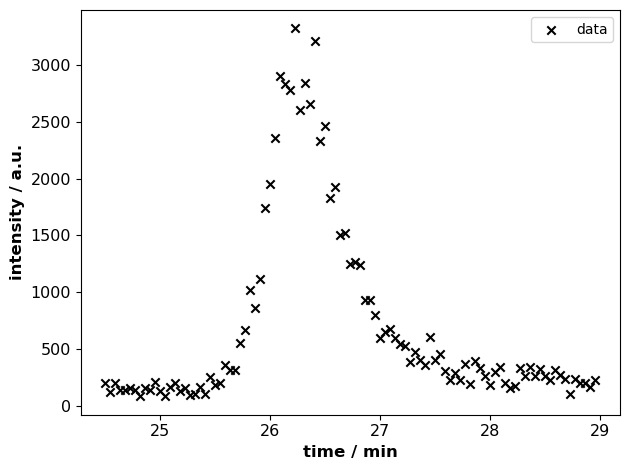

In [7]:
fig, ax = pyplot.subplots()
ax.scatter(time_np, intensity_np, marker="x", color="black", label="data")
pyplot.legend()
ax.set_xlabel("time / min", fontsize=12, fontweight="bold")
ax.set_ylabel("intensity / a.u.", fontsize=12, fontweight="bold")
pyplot.xticks(size=11.5)
pyplot.yticks(size=11.5)
pyplot.tight_layout()
pyplot.show()

In [23]:
with pm.Model() as pmodel:
    # priors
    baseline = pm.Normal("baseline", 100, 50)
    noise = pm.LogNormal("noise", np.log(100), 1)
    mean = pm.Normal("mean", np.mean(time_np[[0, -1]]), np.ptp(time_np) / 2)
    std = pm.HalfNormal("std", np.ptp(time_np) / 3)
    alpha = pm.HalfNormal("alpha", 2.5)
    # when x-axis (time) is in minutes
    area = pm.HalfNormal("area", np.max(intensity_np) * 0.9)
    # when x-axis (time) is in seconds (i.e. for comparison with MultiQuant)
    # area = pm.HalfNormal("area", 50000)

    # posterior with x = time = 0
    pm.Deterministic("height", area * (1 / (std * np.sqrt(2 * np.pi))))
    # posterior
    y = baseline + area * (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((time_np - mean) / std)**2))
    normal_pdf = (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((time_np - mean) / std)**2))
    cumulative_distribution_function = (0.5 * (1 + math.erf(((alpha * (time_np - mean) / std)) / np.sqrt(2))))
    # y = baseline + area * pdf(skew normal)
    # pdf(skew normal) = 2 * normal_pdf *cumulative_distribution_function
    # y = baseline + area * (2 * (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((time_np - mean) / std)**2)) * (0.5 * (1 + math.erf(((alpha * (time_np - mean) / std)) / np.sqrt(2)))))

    y = pm.Deterministic("y", y)

    # likelihood (auf der y-Achse liegende Normalverteilung um Datenpunkte, entspricht hier Normalverteilung um Wert mit Standardabweichung = noise)
    L = pm.Normal("L", mu=y, sigma=noise, observed=intensity_np)

TypeError: must be real number, not TensorVariable

In [32]:
with pm.Model() as pmodel:
    # priors
    baseline = pm.Normal("baseline", 100, 50)
    noise = pm.LogNormal("noise", np.log(100), 1)
    mean = pm.Normal("mean", np.mean(time_np[[0, -1]]), np.ptp(time_np) / 2)
    std = pm.HalfNormal("std", np.ptp(time_np) / 3)
    alpha = pm.HalfNormal("alpha", 2.5)
    # when x-axis (time) is in minutes
    area = pm.HalfNormal("area", np.max(intensity_np) * 0.9)
    # when x-axis (time) is in seconds (i.e. for comparison with MultiQuant)
    # area = pm.HalfNormal("area", 50000)

    # posterior with x = time = 0
    pm.Deterministic("height", area * (1 / (std * np.sqrt(2 * np.pi))))
    # posterior
    y = baseline + area * (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((time_np - mean) / std)**2))
    def normal_pdf(x):
        return (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((x - mean) / std)**2))
    cumulative = scipy.integrate.quad(lambda x: (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((x - mean) / std)**2)), 0.1, 1)
    # y = baseline + area * pdf(skew normal)
    # pdf(skew normal) = 2 * normal_pdf *cumulative_distribution_function
    # y = baseline + area * (2 * (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((time_np - mean) / std)**2)) * (0.5 * (1 + math.erf(((alpha * (time_np - mean) / std)) / np.sqrt(2)))))

    y = pm.Deterministic("y", y)

    # likelihood (auf der y-Achse liegende Normalverteilung um Datenpunkte, entspricht hier Normalverteilung um Wert mit Standardabweichung = noise)
    L = pm.Normal("L", mu=y, sigma=noise, observed=intensity_np)

TypeError: must be real number, not TensorVariable

In [20]:
with pm.Model() as pmodel:
    # priors
    baseline = pm.Normal("baseline", 50, 50)
    noise = pm.LogNormal("noise", np.log(50), 1)
    mean = pm.Normal("mean", np.mean(time_np[[0, -1]]), np.ptp(time_np) / 2)
    std = pm.HalfNormal("std", np.ptp(time_np) / 3)
    # when x-axis (time) is in minutes
    area = pm.HalfNormal("area", np.max(intensity) * 0.9)
    # when x-axis (time) is in seconds (i.e. for comparison with MultiQuant)
    # area = pm.HalfNormal("area", 50000)

    # posterior with x = time = 0
    pm.Deterministic("height", baseline + area * (1 / (std * np.sqrt(2 * np.pi))))
    # posterior
    y = baseline + area * (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((time_np - mean) / std)**2))
    y = pm.Deterministic("y", y)

    # likelihood (auf der y-Achse liegende Normalverteilung um Datenpunkte, entspricht hier Normalverteilung um Wert mit Standardabweichung = noise)
    L = pm.Normal("L", mu=y, sigma=noise, observed=intensity)

In [ ]:
with pmodel:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample())

In [ ]:
fig, ax = pyplot.subplots()

pm.gp.util.plot_gp_dist(
    ax=ax,
    x=time,
    samples=idata.posterior.y.stack(sample=("chain", "draw")).T.values,
)
ax.scatter(time, intensity, marker="x", color="black", label="data")
ax.set_xlabel("time / min", fontsize=12, fontweight="bold")
ax.set_ylabel("intensity / a.u.", fontsize=12, fontweight="bold")
# plot baseline
x = np.array(ax.get_xlim())
y_baseline = az.summary(idata).loc["baseline","mean"]
y = [y_baseline] * len(x)
pyplot.plot(x, y)
pyplot.legend()
pyplot.tight_layout()
pyplot.show()